In [16]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_context('talk')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
%config InlineBackend.figure_format = 'retina'
from datetime import timedelta
import datetime as dt
import scipy
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
url='https://data.cdc.gov/api/views/muzy-jte6/rows.csv?accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B'

USdf=pd.read_csv(url,delimiter=';',thousands=',')
USdf['Week Ending Date']=pd.to_datetime(USdf['Week Ending Date'])
USdf.rename(columns={'All Cause':'deaths'},inplace=True)

In [18]:
USdf.columns


Index(['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week',
       'Week Ending Date', 'deaths', 'Natural Cause', 'Septicemia (A40-A41)',
       'Malignant neoplasms (C00-C97)', 'Diabetes mellitus (E10-E14)',
       'Alzheimer disease (G30)', 'Influenza and pneumonia (J09-J18)',
       'Chronic lower respiratory diseases (J40-J47)',
       'Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)',
       'Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)',
       'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)',
       'Diseases of heart (I00-I09,I11,I13,I20-I51)',
       'Cerebrovascular diseases (I60-I69)',
       'COVID-19 (U071, Multiple Cause of Death)',
       'COVID-19 (U071, Underlying Cause of Death)', 'flag_allcause',
       'flag_natcause', 'flag_sept', 'flag_neopl', 'flag_diab', 'flag_alz',
       'flag_inflpn', 'flag_clrd', 'flag_otherresp', 'flag_nephr',
       'flag_otherunk', 'flag_hd',

In [19]:
US=USdf.loc[USdf['Jurisdiction of Occurrence']=='United States']
US['Week Ending Date']

4873   2019-01-05
4874   2019-01-12
4875   2019-01-19
4876   2019-01-26
4877   2019-02-02
          ...    
4960   2020-09-05
4961   2020-09-12
4962   2020-09-19
4963   2020-09-26
4964   2020-10-03
Name: Week Ending Date, Length: 92, dtype: datetime64[ns]

In [25]:
US['COVID-19 (U071, Multiple Cause of Death)'].sum()-US['COVID-19 (U071, Underlying Cause of Death)'].sum()

16341.0

<AxesSubplot:xlabel='Week Ending Date'>

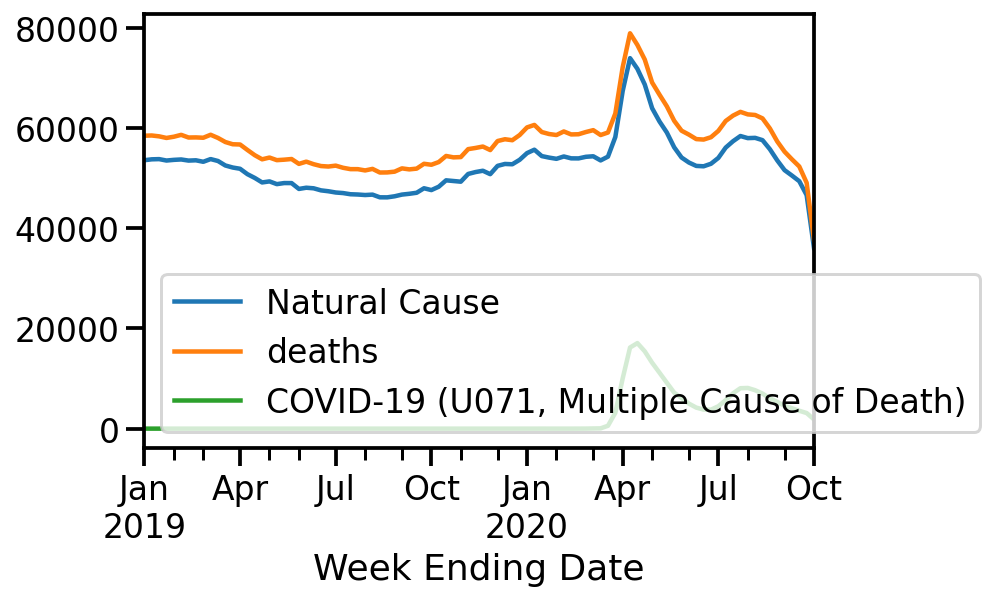

In [5]:
US.plot(x='Week Ending Date',y=['Natural Cause','deaths','COVID-19 (U071, Multiple Cause of Death)'])

In [6]:
urlbaseline='https://data.cdc.gov/api/views/xkkf-xrst/rows.csv?accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B'

USbaselinedf=pd.read_csv(urlbaseline,delimiter=';',thousands=',')
USbaselinedf['Week Ending Date']=pd.to_datetime(USbaselinedf['Week Ending Date'])
USbaseline=USbaselinedf.loc[USbaselinedf.State=='United States']

In [7]:
US=pd.merge(USbaseline,US,on='Week Ending Date',how='inner')

In [8]:
US=pd.concat([US['Week Ending Date'],US['deaths'], US['Average Expected Count'],US['COVID-19 (U071, Multiple Cause of Death)']], 
             axis=1, 
             keys=['Week Ending Date' ,'deaths','baseline','coviddeaths'])

<AxesSubplot:xlabel='Week Ending Date'>

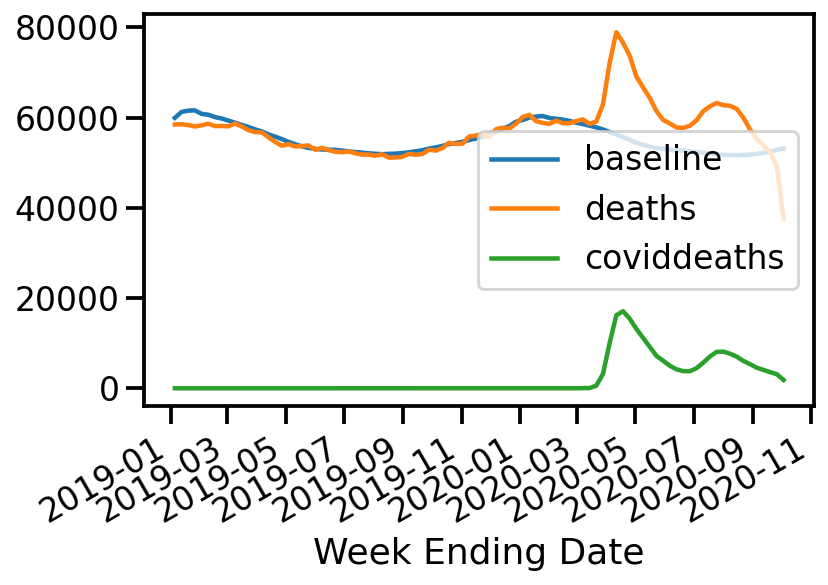

In [9]:
US.plot(x='Week Ending Date',y=['baseline','deaths','coviddeaths'])

In [10]:
def resample_daily(df,dates_to_resample,dailydatesname):
    df2=df.copy()
    df2=(1/7)*(df.set_index(dates_to_resample).resample('D').mean())
    df2.interpolate(inplace=True)
    df2[dailydatesname]=df2.index
    df2.reset_index(drop=True,inplace=True)
    
    return df2

In [11]:
USdaily=resample_daily(US,'Week Ending Date','date')

In [12]:
USdaily.coviddeaths.sum()
USdaily['noncovid']=USdaily.deaths-USdaily.coviddeaths

In [13]:
USdaily.coviddeaths.sum()

201957.7142857143

In [19]:
USdaily.loc[USdaily.date> dt.datetime(2019,12,1)]

,deaths,baseline,coviddeaths,date,noncovid
331,8018.632653,8086.040816,0.000000,2019-12-02,8018.632653
332,8055.448980,8093.346939,0.000000,2019-12-03,8055.448980
333,8092.265306,8100.653061,0.000000,2019-12-04,8092.265306
334,8129.081633,8107.959184,0.000000,2019-12-05,8129.081633
335,8165.897959,8115.265306,0.000000,2019-12-06,8165.897959
...,...,...,...,...,...
633,6311.061224,7563.299320,366.673469,2020-09-29,5944.387755
634,6077.510204,7570.653061,340.612245,2020-09-30,5736.897959
635,5843.959184,7578.006803,314.551020,2020-10-01,5529.408163
636,5610.408163,7585.360544,288.489796,2020-10-02,5321.918367


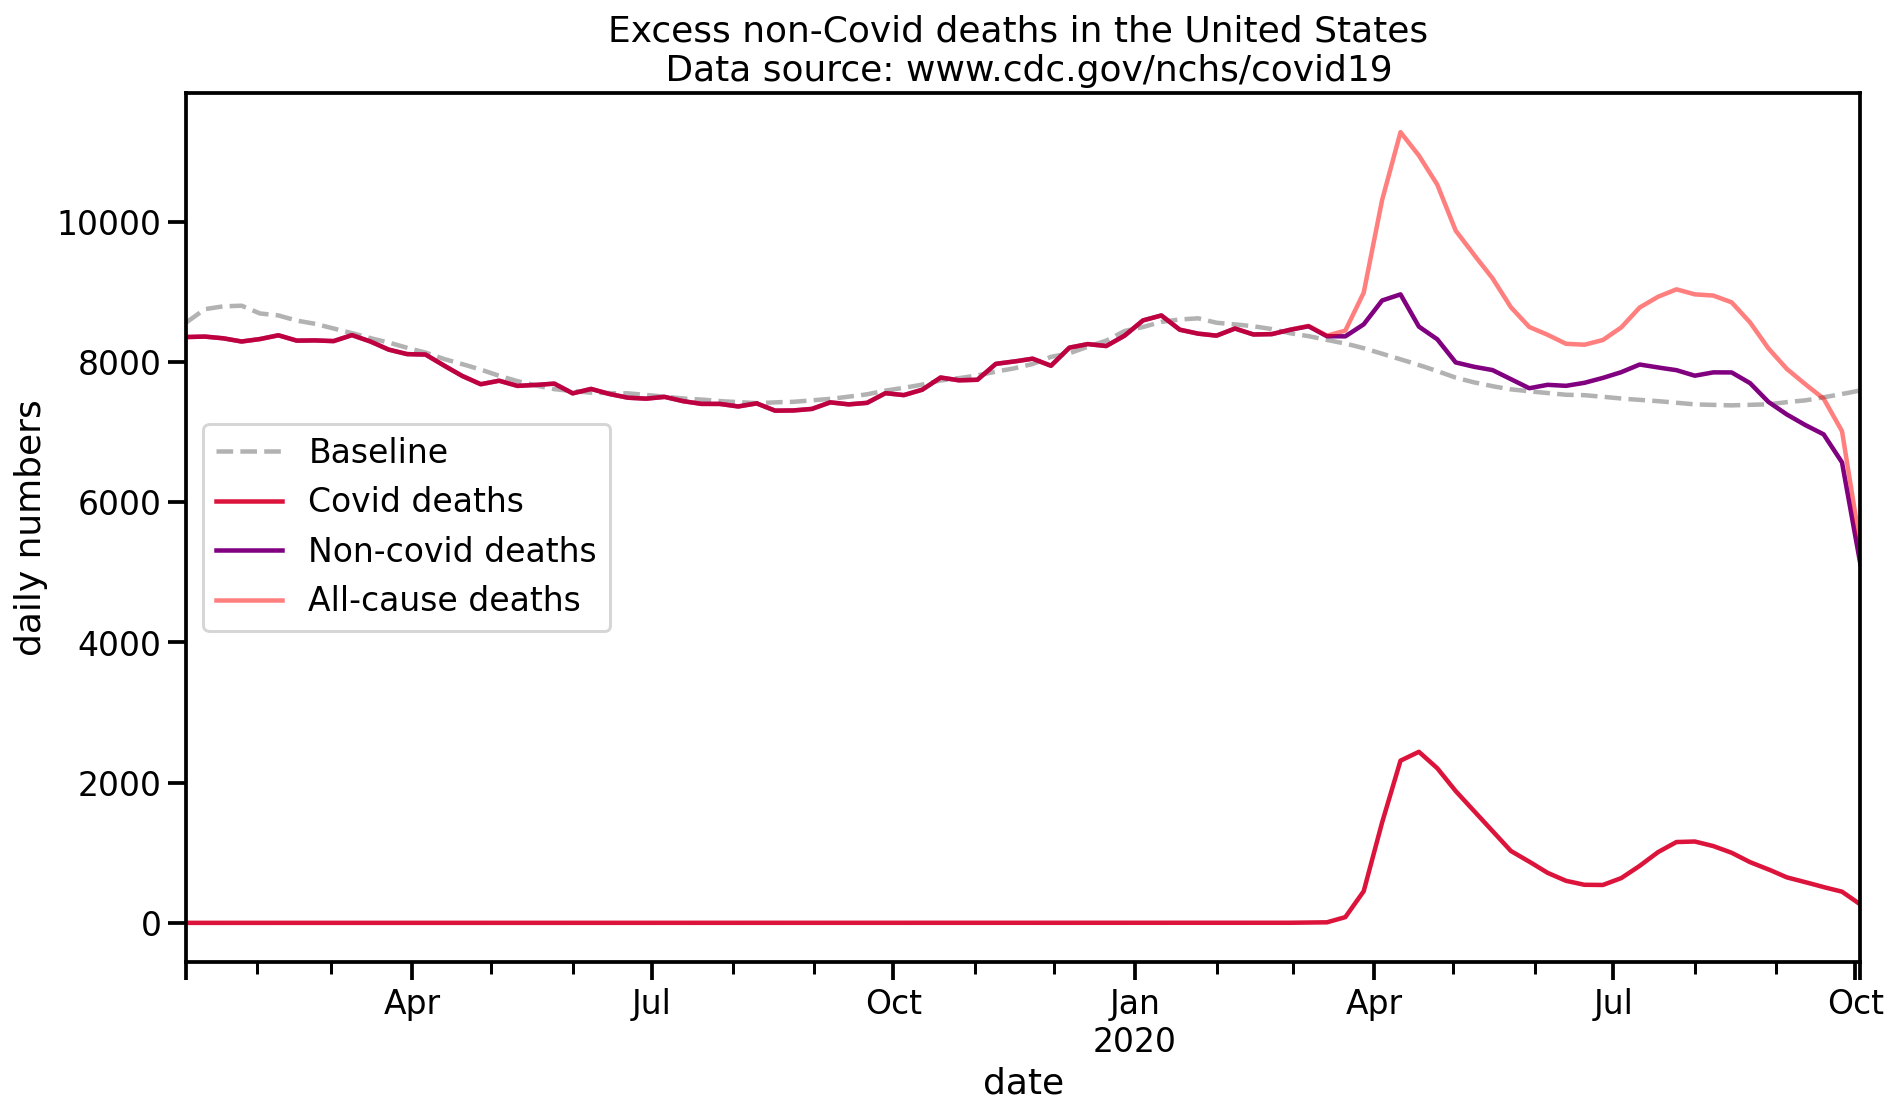

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.title('Excess non-Covid deaths in the United States \n Data source: www.cdc.gov/nchs/covid19')


USdaily.plot(x='date',y='baseline',color='gray',ax=ax,
             alpha=0.6,label='Baseline',linestyle='--')
USdaily.plot(x='date',y='coviddeaths',color='crimson',ax=ax,
             alpha=1,label='Covid deaths')
USdaily.plot(x='date',y='noncovid',color='purple',ax=ax,
             alpha=1,label='Non-covid deaths')
USdaily.plot(x='date',y='deaths',color='red',ax=ax,
             alpha=0.5,label='All-cause deaths')
plt.legend()
plt.ylabel('daily numbers')

fig.set_facecolor('w')

sns.despine;

plt.savefig('USdeaths.png',dpi=200)
plt.show()

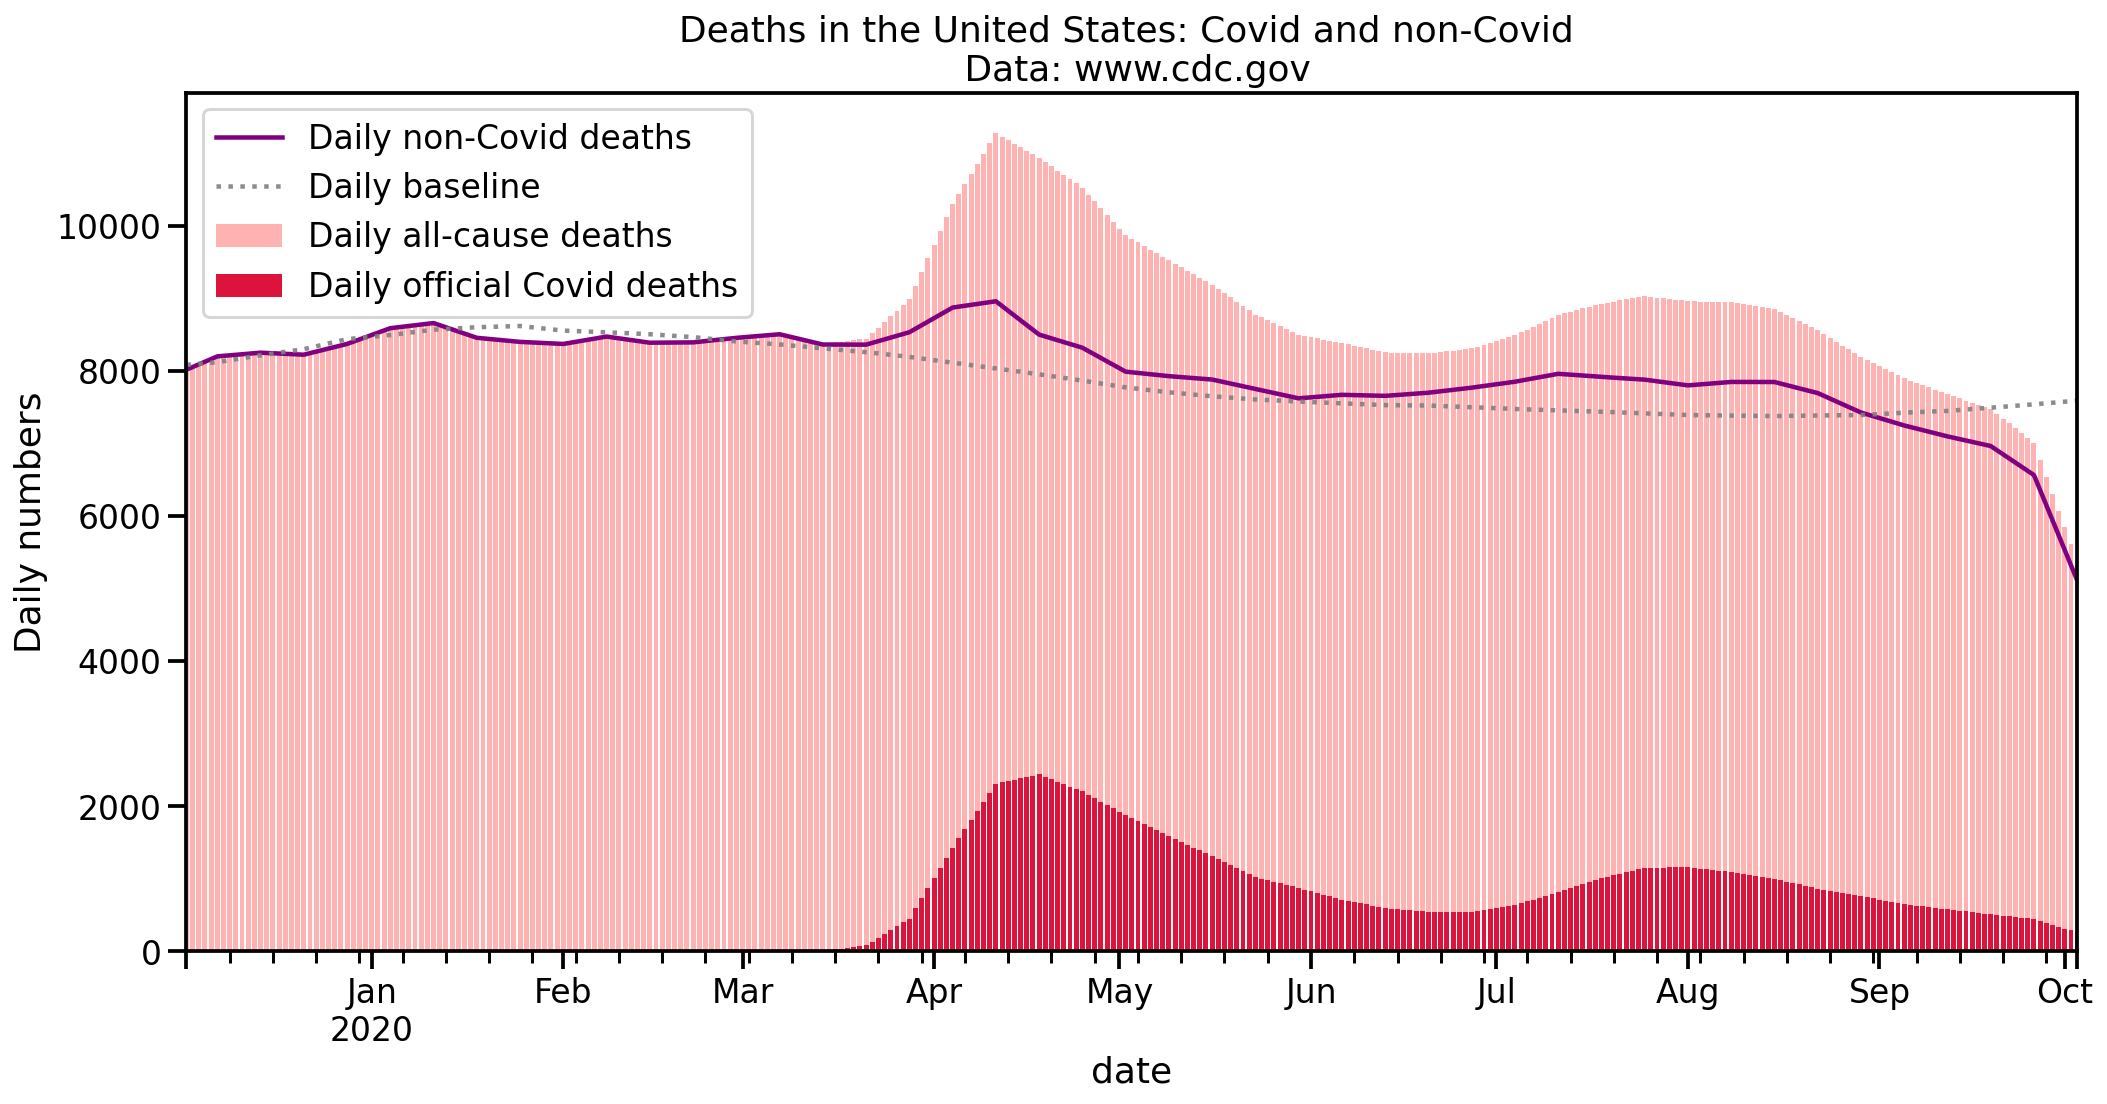

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))

USdaily=USdaily.loc[USdaily.date> dt.datetime(2019,12,1)]

#index=df[df.date>=covid.date.min()].index

#df.iloc[index].plot(x='date',y='dailyexcesssmooth',ax=ax,label='Daily excess deaths with respect to Euromomo baseline',color='blue')

ax.bar(USdaily.date,USdaily.deaths,label='Daily all-cause deaths',color='red',alpha=0.3)
ax.bar(USdaily.date,USdaily.coviddeaths,label='Daily official Covid deaths',color='crimson')

#df2.plot.bar(x='date',y='coviddeaths',ax=ax,label='Daily official Covid deaths',color='red')
USdaily.plot(x='date',y='noncovid',ax=ax,label='Daily non-Covid deaths',color='purple')
USdaily.plot(x='date',y='baseline',ax=ax,label='Daily baseline',color='gray',alpha=0.9,linestyle=':')

plt.xlabel('date')# ,fontsize = 20)
plt.ylabel('Daily numbers')# ,fontsize = 20)


plt.title('Deaths in the United States: Covid and non-Covid \n Data: www.cdc.gov' )
#plt.title('EUROMOMO excess deaths during epidemic')

plt.legend(loc='upper left')
fig.set_facecolor('w')
plt.tight_layout();
sns.despine;

plt.savefig('USACovidnonCovid.png',dpi=250)

In [ ]:
# Get total of Covid deaths
covid=df.groupby('date',as_index=False)[('deaths','positive')].agg('sum')
covid['date']=covid.date.dt.tz_localize(None)


fig, ax = plt.subplots(figsize=(15, 8))
plt.title('Official Covid numbers in Euromomo countries')
covid.plot(x='date',y='positive',ax=ax,color='orange',label='cases')#
covid.plot(x='date',y='deaths',ax=ax,color='blue',label='deaths')#
plt.legend()
plt.ylabel('daily numbers')

fig.set_facecolor('w')

sns.despine;
plt.savefig('OfficialCovidAll.png',dpi=250)
plt.show()

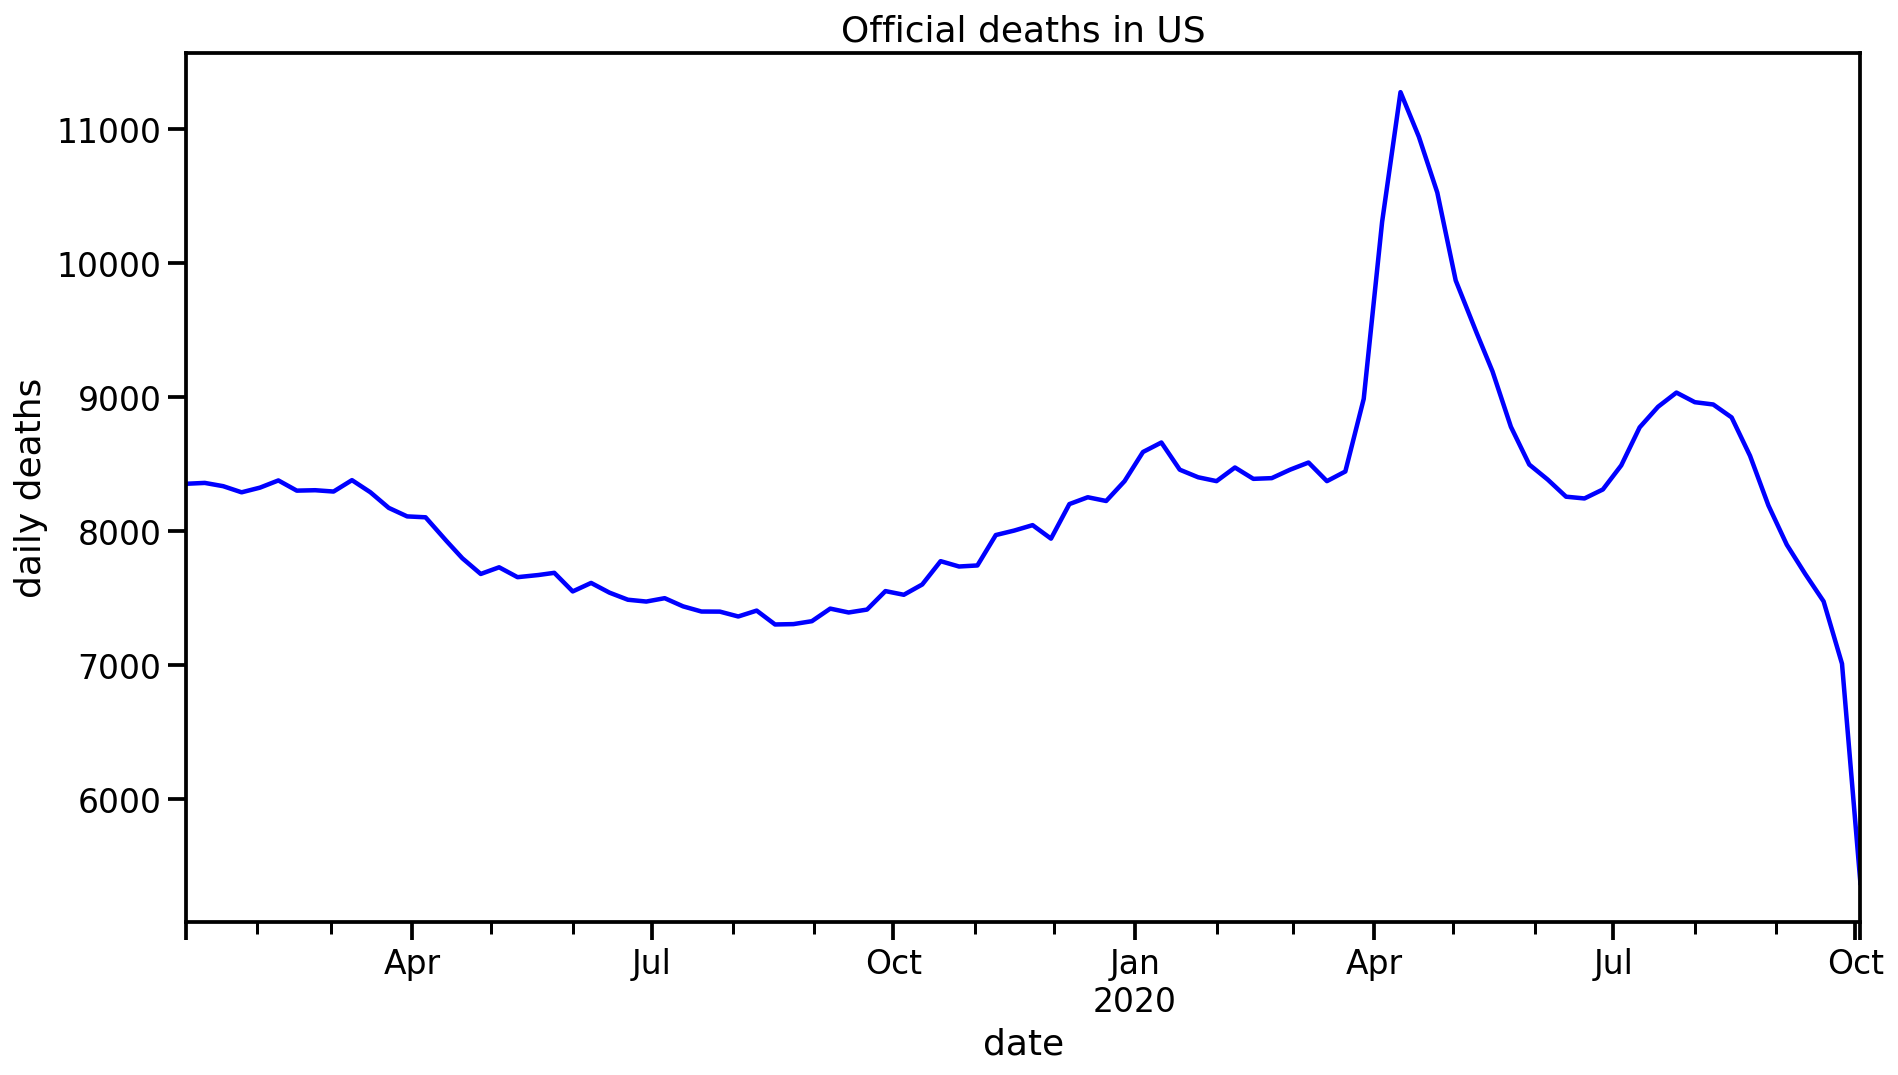

In [150]:
df=USdaily

# Get total of Covid deaths
covid=df.groupby('date',as_index=False).agg('sum')
covid['date']=covid.date.dt.tz_localize(None)


fig, ax = plt.subplots(figsize=(15, 8))
plt.title('Official deaths in US')

covid.plot(x='date',y='deaths',ax=ax,color='blue',legend=False)#
#plt.legend()
plt.ylabel('daily deaths')

fig.set_facecolor('w')

sns.despine;
plt.savefig('USOfficialCovidDeaths.png',dpi=250)
plt.show()

In [9]:
#weekly deaths
covidweekly= covid.resample('W', on='date').sum()
covidweekly.reset_index(level=0, inplace=True)





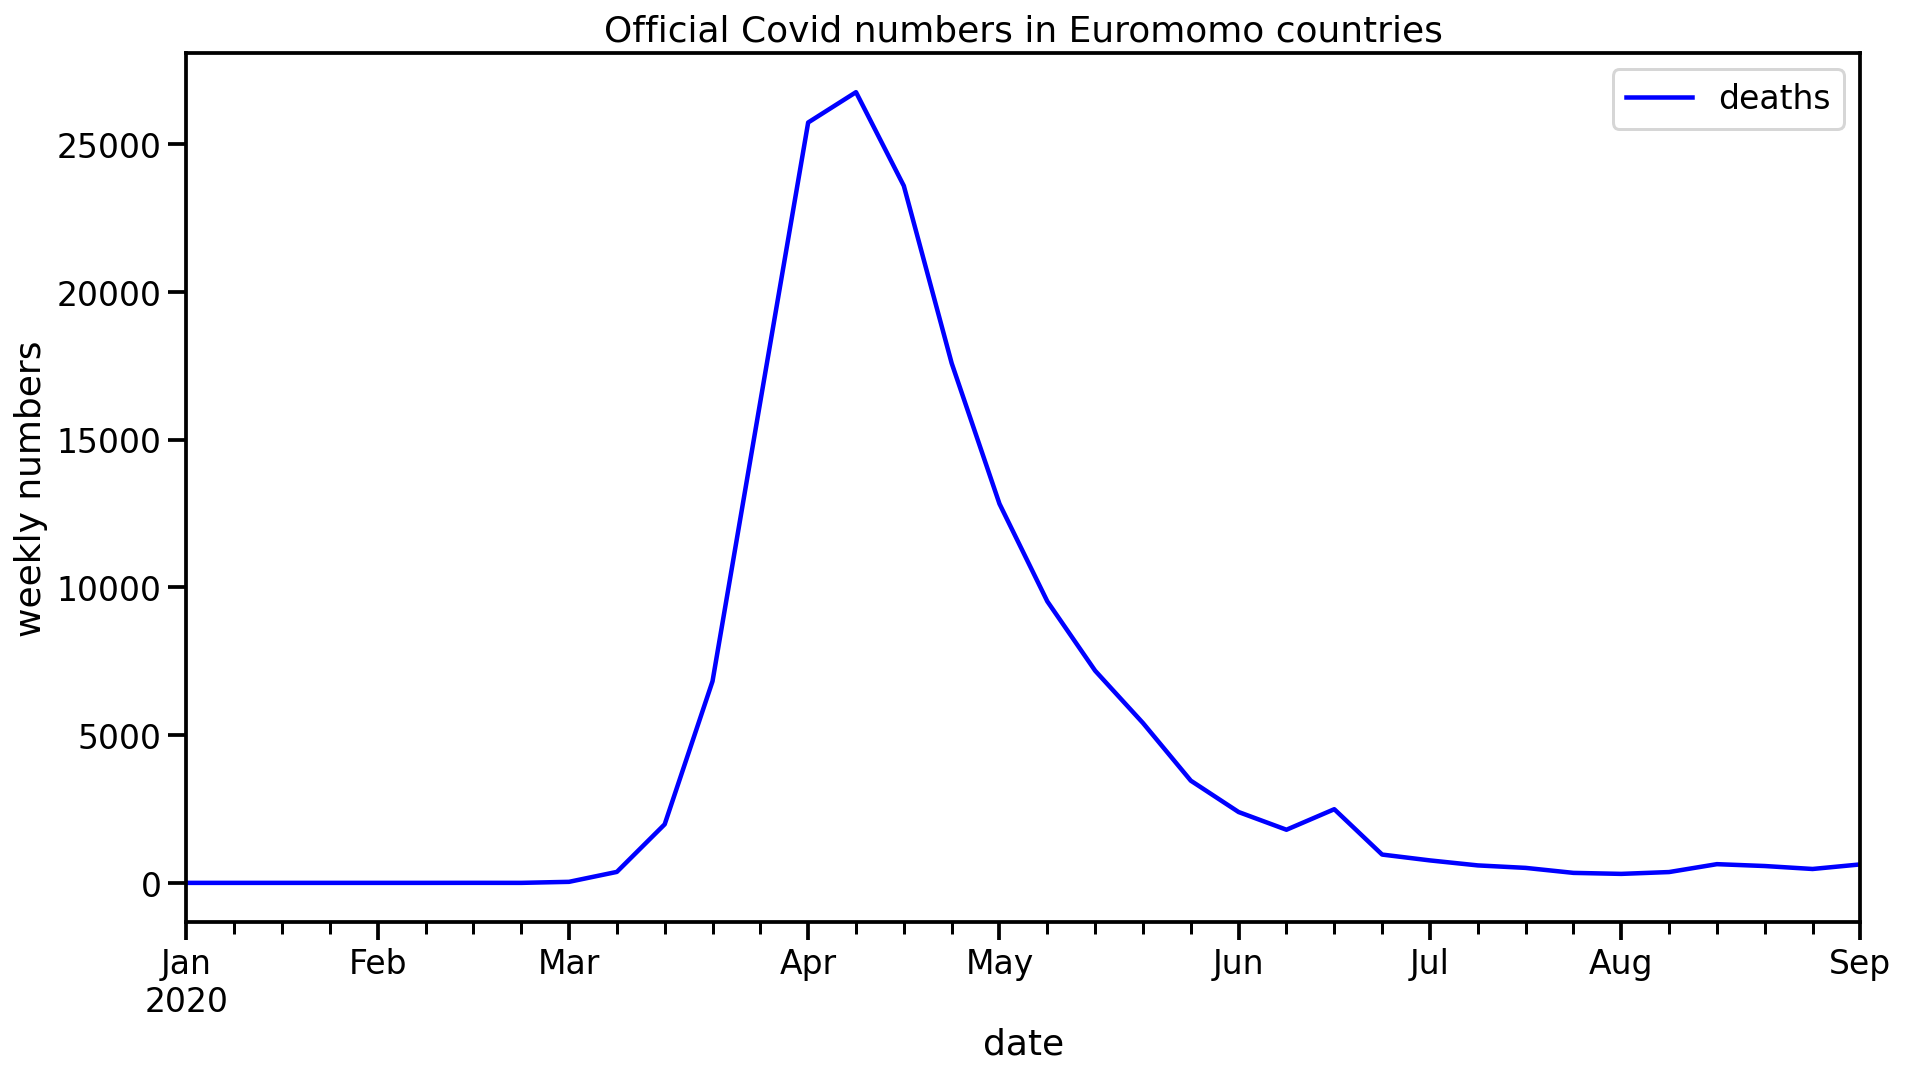

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.title('Official Covid numbers in Euromomo countries')
#covidweekly.plot(x='date',y='positive',ax=ax,color='orange',label='cases')#
covidweekly.plot(x='date',y='deaths',ax=ax,color='blue',label='deaths')#
plt.legend()
plt.ylabel('weekly numbers')
sns.despine;
plt.savefig('OfficialCovidWeekly.png',dpi=250)
plt.show()

In [17]:
dataeuromomo=get_euromomo_data()
dataeuromomo.tail()

Data source: https://www.euromomo.eu/component---src-templates-graphs-and-maps-js-a4579e668435f36d36c2.js


,date,deaths,baseline,baseline_upper,baseline_lower
195,2020-08-04,50493.49,47151.08,48246.25,46064.33
196,2020-08-11,49385.64,47212.52,48308.79,46124.66
197,2020-08-18,51910.55,47329.72,48426.79,46241.07
198,2020-08-25,47142.21,47501.53,48599.17,46412.28
199,2020-09-01,44955.36,47726.14,48824.32,46636.33


In [41]:

dataeuromomo['dateindex']=np.array(dataeuromomo.index)

In [46]:
data=US

In [47]:
from scipy.signal import find_peaks, peak_prominences
peaks, _= find_peaks(data.deaths.values,prominence=10000)
troughs, _= find_peaks(-data.deaths.values,prominence=10000)
troughs=np.append(troughs,[data.index[-1]])
#troughs=np.append([data.index[0]],troughs)

prominences = peak_prominences(data.deaths.values, peaks)[0]

contour_heights = data.deaths.iloc[peaks] - prominences

KeyError: 'date'

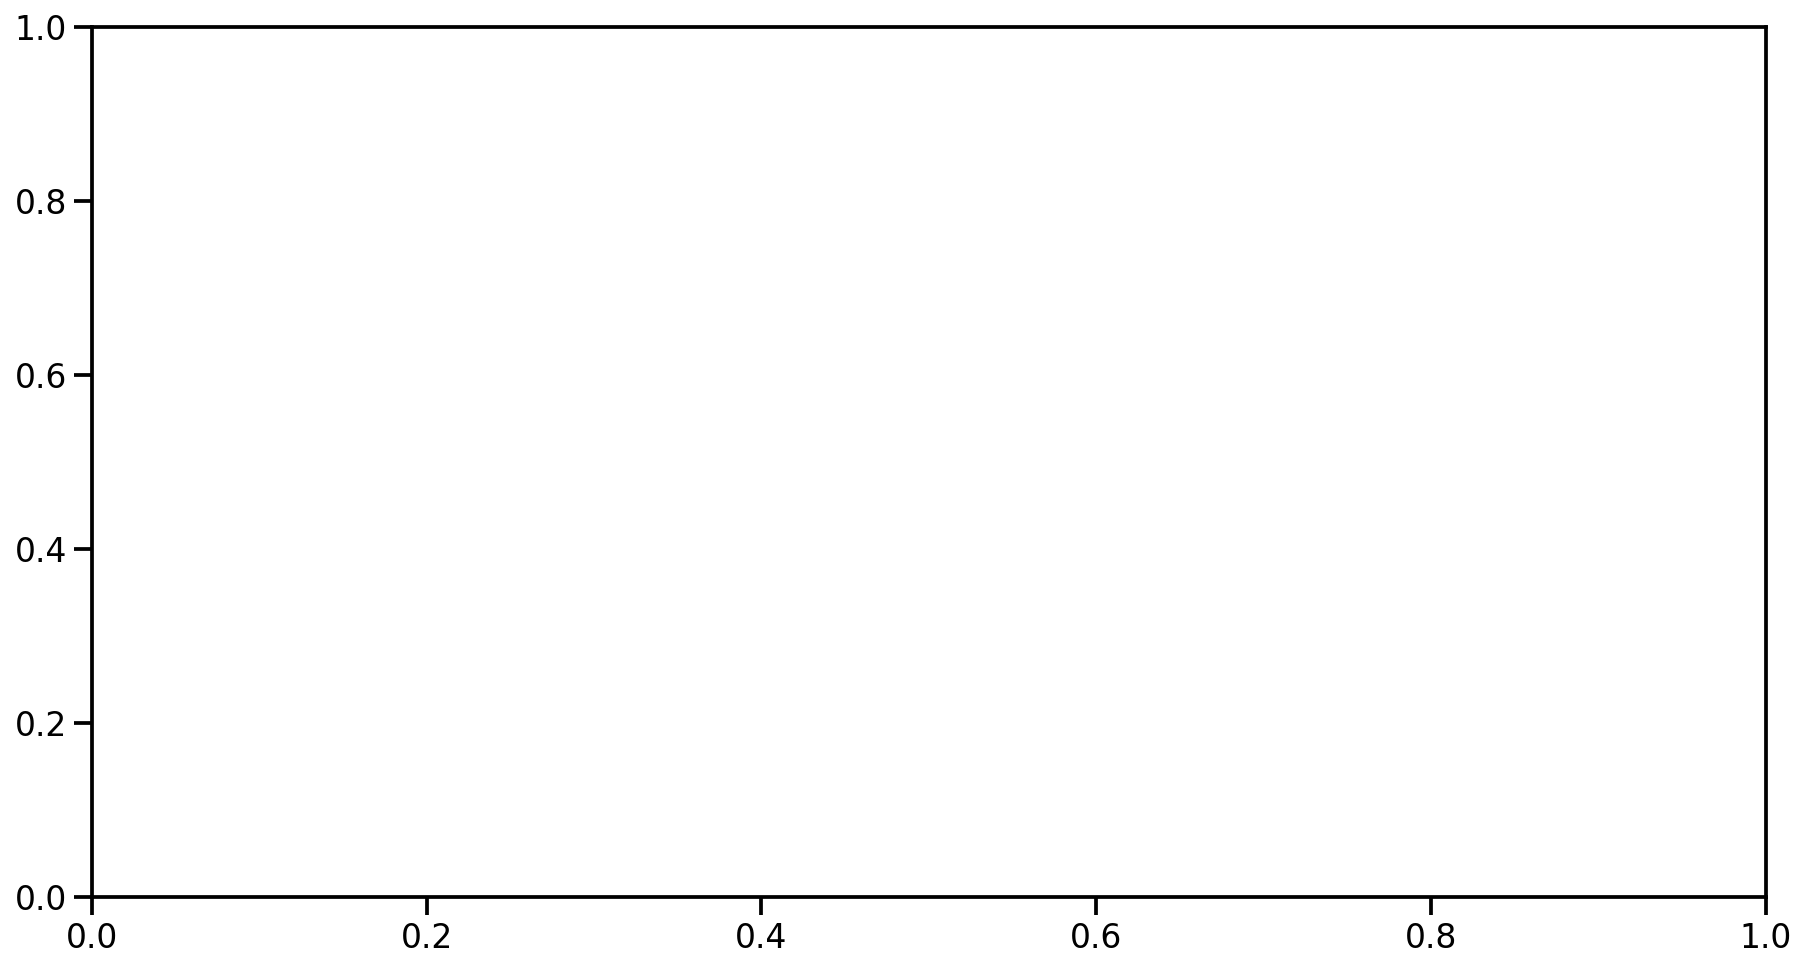

In [48]:

fig, ax = plt.subplots(figsize=(15, 8))
data.plot(x="date", y="deaths",color='blue',ax=ax)
data.loc[troughs].plot.scatter(x='date',y='deaths',marker='v',color='green',s=150,ax=ax)
data.loc[peaks].plot.scatter(x='date',y='deaths',marker='^',color='red',s=150,ax=ax)
data.plot(x='date',y='baseline',color='gray',ax=ax)

ax.fill_between(data.date,data.baseline_upper,data.baseline_lower, alpha=0.35,color='gray')

sns.despine;
plt.show()

In [15]:
#Find the cumulative sum of deaths in each peak

totaldeathsarray=[]

for i in np.arange(len(peaks)-1):
    totaldeaths=data.deaths.iloc[troughs[i]:troughs[i+1]].sum()
    totaldeathsarray.append(totaldeaths)

In [16]:
def weekdiff(start, end):
    days = pd.to_datetime(end) - pd.to_datetime(start)
    week = int(pd.Timedelta(days).days / 7)
    remainder = pd.Timedelta(days).days % 7
    #print(week)
    return week

trough_to_trough_interval=[]
intervaldates=[]

for i in np.arange(1,len(troughs)):

    trough_to_trough_interval.append(weekdiff(data.date.iloc[troughs[i-1]],data.date.iloc[troughs[i]]))
    intervaldates.append((data.date.iloc[troughs[i-1]].strftime("%d %b %Y") ,data.date.iloc[troughs[i]].strftime("%d %b %Y") ))

In [17]:
# Find the start and end points of the pandemic spike
pandemic=data[(data.date>pd.Timestamp('2020-02-26')) & (data.date<pd.Timestamp('2020-06-08'))]

#x=data.copy()
#x.deaths.iloc[pandemic.index]=None

#x.interpolate(inplace=True,method='spline',order=5)



data['noncovidbaseline']=data.deaths
data.loc[pandemic.index.values,'noncovidbaseline']=None

data['noncovidbaseline']=data['noncovidbaseline'].interpolate(method='akima')

#pandemic.iloc[pandemic.index[0]-1]= data.iloc[pandemic.index[0]-1]

#.append(data.iloc[pandemic.index[-1]+1])

#pandemic.append(pandemic.index[-1]+1)

In [18]:
def insert_row(idx, df, df_insert):
    return df.iloc[:idx, ].append(df_insert).append(df.iloc[idx:, ]) #.reset_index(drop = True)

In [19]:
last_index=pandemic.index[-1]
first_index=pandemic.index[0]

pandemic=insert_row(first_index-1,pandemic,data.iloc[first_index-1])
pandemic=insert_row(last_index+1,pandemic,data.iloc[last_index+1])
pandemic.sort_index(inplace=True)

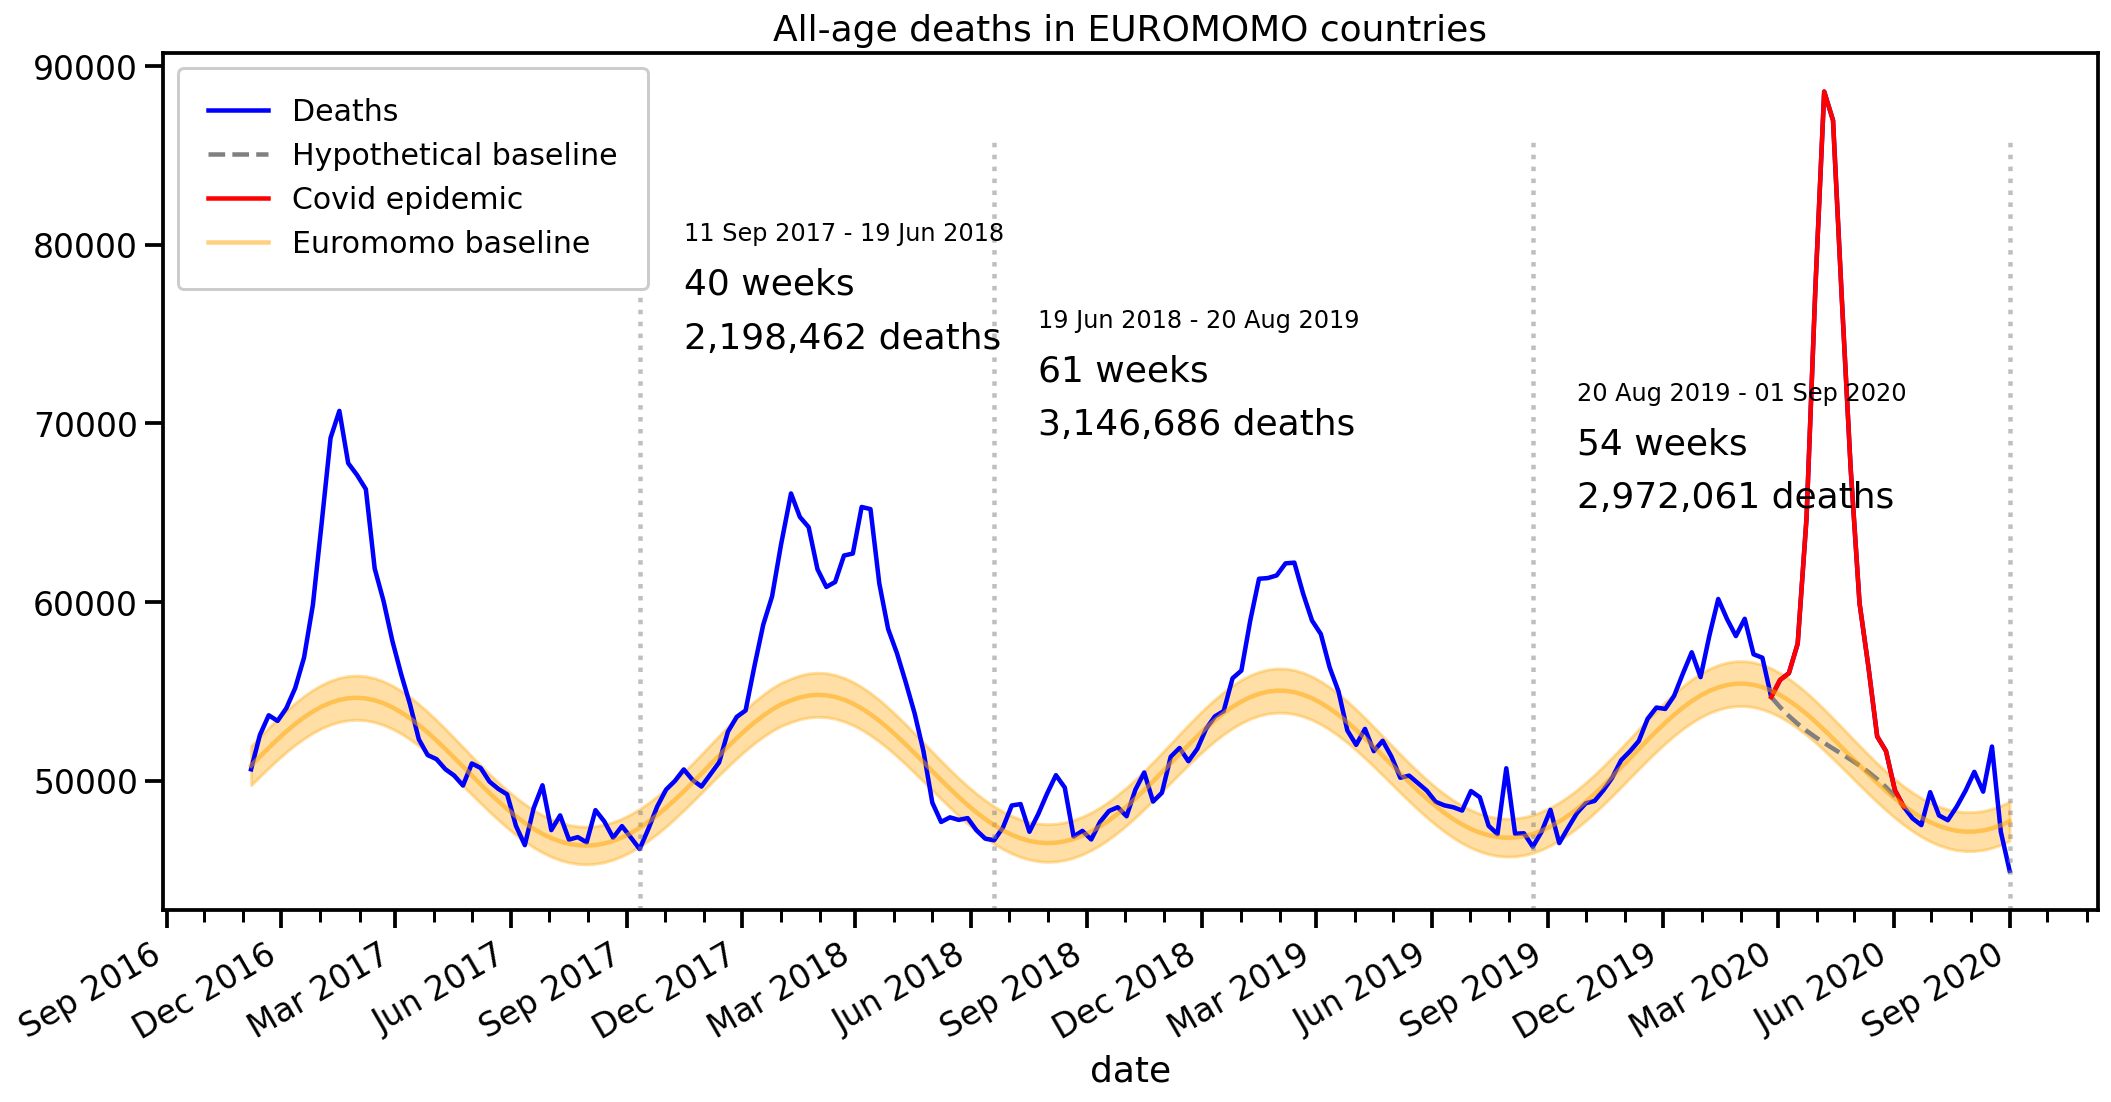

In [20]:
#sns.set()
fig, ax = plt.subplots(figsize=(15, 8))

data.plot(x="date", y="deaths",color='blue',ax=ax,legend=True,label='Deaths')
data.iloc[pandemic.index].plot(x='date',y='noncovidbaseline',color='gray',ax=ax,legend=True,label='Hypothetical baseline',
                              linestyle='--')

pandemic.plot(x="date", y="deaths",color='red',ax=ax,label='Covid epidemic')

#sns.scatterplot(x='date',y='deaths',data=data.loc[troughs],marker='v',color='green',s=150)
#sns.scatterplot(x='date',y='deaths',data=data.loc[peaks],marker='^',color='red',s=150)
#plt.ylim([40e3,100e3])
plt.title('All-age deaths in EUROMOMO countries')
for i in np.arange(len(troughs)):
    plt.axvline(data.date.iloc[troughs[i]],ymax=0.9,color='gray',alpha=0.5,linestyle=':')
for i in np.arange(len(troughs)-1):
    ax.annotate('{} - {}'.format(intervaldates[i][0],intervaldates[i][1]), xy=(data.date.iloc[peaks[i]], data.deaths.iloc[troughs[i]]  ),
                xytext=(data.date.iloc[troughs[i]+5], 1.05*data.deaths.iloc[peaks[i]]+6000),size=12)
    ax.annotate('{:,} weeks'.format(trough_to_trough_interval[i]), xy=(data.date.iloc[peaks[i]], data.deaths.iloc[troughs[i]]  ),
                xytext=(data.date.iloc[troughs[i]+5], 1.05*data.deaths.iloc[peaks[i]]+3000))
    ax.annotate('{:,} deaths'.format(int(totaldeathsarray[i])), xy=(data.date.iloc[peaks[i]], data.deaths.iloc[troughs[i]]  ),
                xytext=(data.date.iloc[troughs[i]+5], 1.05*data.deaths.iloc[peaks[i]]))
#sns.set(font_scale=5) 
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})




ax.xaxis.set_major_locator(mdates.YearLocator())

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

ax.xaxis.set_minor_locator(mdates.MonthLocator())


#plt.vlines(x=data.date.iloc[peaks], ymin=contour_heights, ymax=data.deaths.iloc[peaks])

#ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.get_xaxis().set_tick_params(which='major', pad=5)

data.plot(x='date',y='baseline',color='orange',ax=ax,label='Euromomo baseline',alpha=0.5)

ax.fill_between(data.date,data.baseline_upper,data.baseline_lower, alpha=0.35,color='orange')


#x.plot(x="date", y="deaths",color='green',ax=ax,legend=False)


ax.legend(fancybox=True, framealpha=1, shadow=False, borderpad=1,loc='upper left',fontsize='small',facecolor='white')

fig.set_facecolor('w')

#plt.show()
plt.tight_layout();
sns.despine;


plt.savefig('Euromomo_total_deaths.jpg',dpi=250)
 

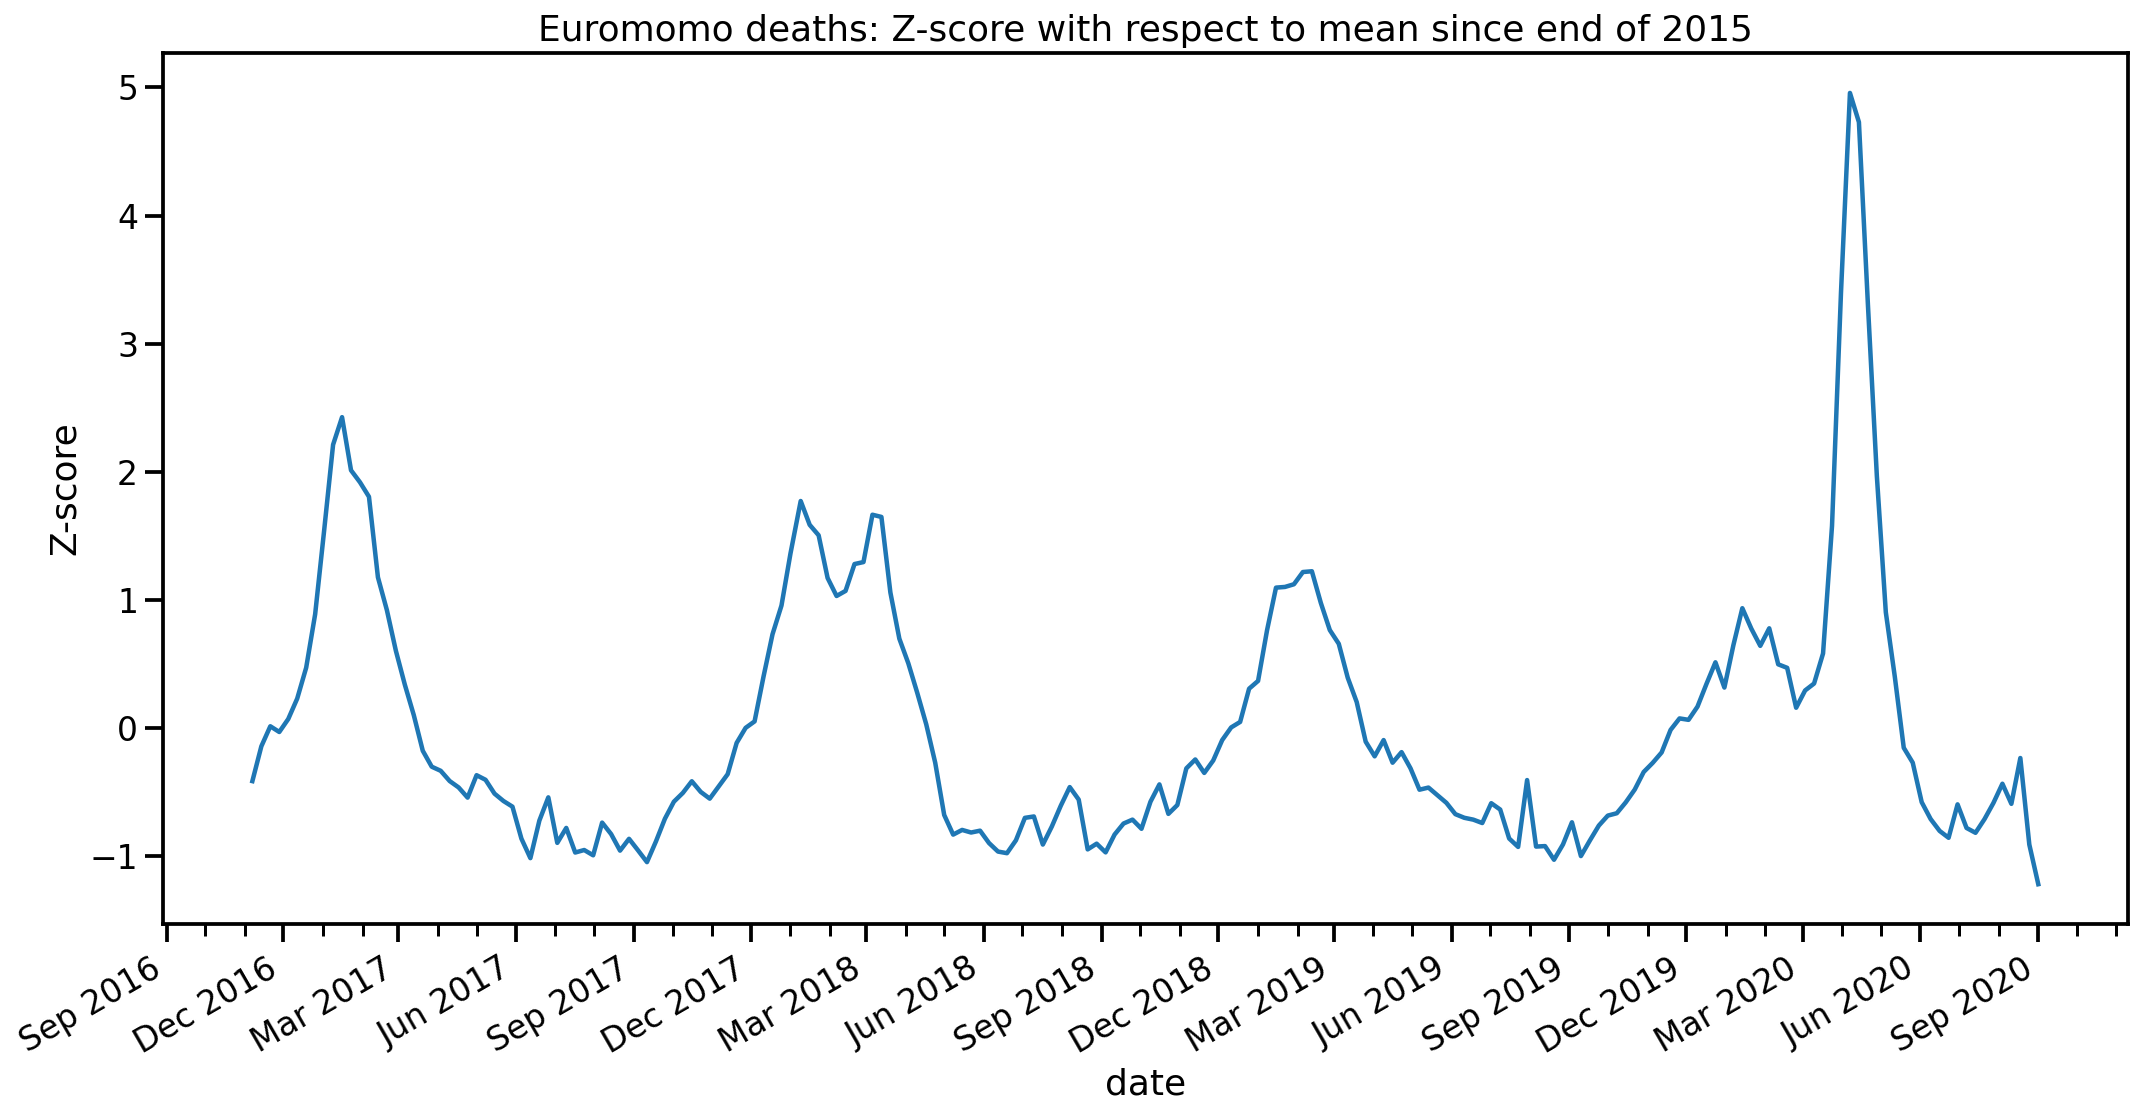

In [21]:
def calc_z_score(intensity):
    mean_int = np.mean(intensity)
    std_int = np.std(intensity)
    z_scores = (intensity - mean_int) / std_int
    return z_scores

#wavelength=data.date.index
deaths=data.deaths.values

z_score = np.array(calc_z_score(deaths))

data['intensity_z_score']=pd.Series(z_score)

threshold = 3.5
abs_z_score = abs(z_score)

data['abs_z_score']=pd.Series(abs_z_score)


fig, ax = plt.subplots(figsize=(15, 8))
data.plot(x='date',y='intensity_z_score',ax=ax,legend=False)
#plt.xticks(fontsize = 15)
#plt.yticks(fontsize = 15)
plt.xlabel('date')# ,fontsize = 20)
plt.ylabel('Z-score')# ,fontsize = 20)
plt.title('Euromomo deaths: Z-score with respect to mean since end of 2015')


fig.set_facecolor('w')
plt.tight_layout();
sns.despine;

ax.xaxis.set_major_locator(mdates.YearLocator())

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

ax.xaxis.set_minor_locator(mdates.MonthLocator())

#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.get_xaxis().set_tick_params(which='major', pad=5)

plt.savefig('zscore_deaths.jpg',dpi=250)


In [54]:
# First we calculated Delta x(i):
dist = 0
delta_intensity = [] 
for i in np.arange(len(deaths)-1):
    dist = deaths[i+1] - deaths[i]
    delta_intensity.append(dist)
    
delta_int = np.array(delta_intensity)
# Alternatively to the for loop one can use: 
# delta_int = np.diff(intensity)

modified_z_score_delta = np.array(calc_modified_z_score(delta_int))

data['modified_z_score_delta']=None
data.modified_z_score_delta.iloc[1:]=modified_z_score_delta


/Users/ivandebono/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [52]:
data

,date,deaths,baseline,baseline_upper,baseline_lower,noncovidbaseline,intensity_z_score,abs_z_score,modified_z_score,euromomoexcess,totalcoviddeaths,euromomototalcoviddeaths,coviddeaths
0,2016-11-07,50638.00,50844.56,51946.99,49750.05,50638.00,-0.415585,0.415585,None,-206.56,0.000000,NaN,0.0
1,2016-11-14,52556.00,51347.12,52462.65,50239.61,52556.00,-0.143934,0.143934,1.33349,1208.88,0.000000,NaN,0.0
2,2016-11-21,53661.00,51838.72,52968.85,50716.75,53661.00,0.012570,0.012570,0.760486,1822.28,0.000000,NaN,0.0
3,2016-11-28,53346.00,52311.76,53457.52,51174.30,53346.00,-0.032045,0.032045,-0.240339,1034.24,0.000000,NaN,0.0
4,2016-12-05,54061.00,52758.70,53920.63,51605.24,54061.00,0.069223,0.069223,0.485612,1302.30,0.000000,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2020-08-04,50493.49,47151.08,48246.25,46064.33,50493.49,-0.436052,0.436052,0.727487,3342.41,178535.240041,NaN,0.0
196,2020-08-11,49385.64,47212.52,48308.79,46124.66,49385.64,-0.592960,0.592960,-0.799145,2173.12,178535.240041,NaN,0.0
197,2020-08-18,51910.55,47329.72,48426.79,46241.07,51910.55,-0.235351,0.235351,1.76125,4580.83,178535.240041,NaN,0.0
198,2020-08-25,47142.21,47501.53,48599.17,46412.28,47142.21,-0.910702,0.910702,-3.37908,-359.32,178535.240041,NaN,0.0


In [ ]:
mo

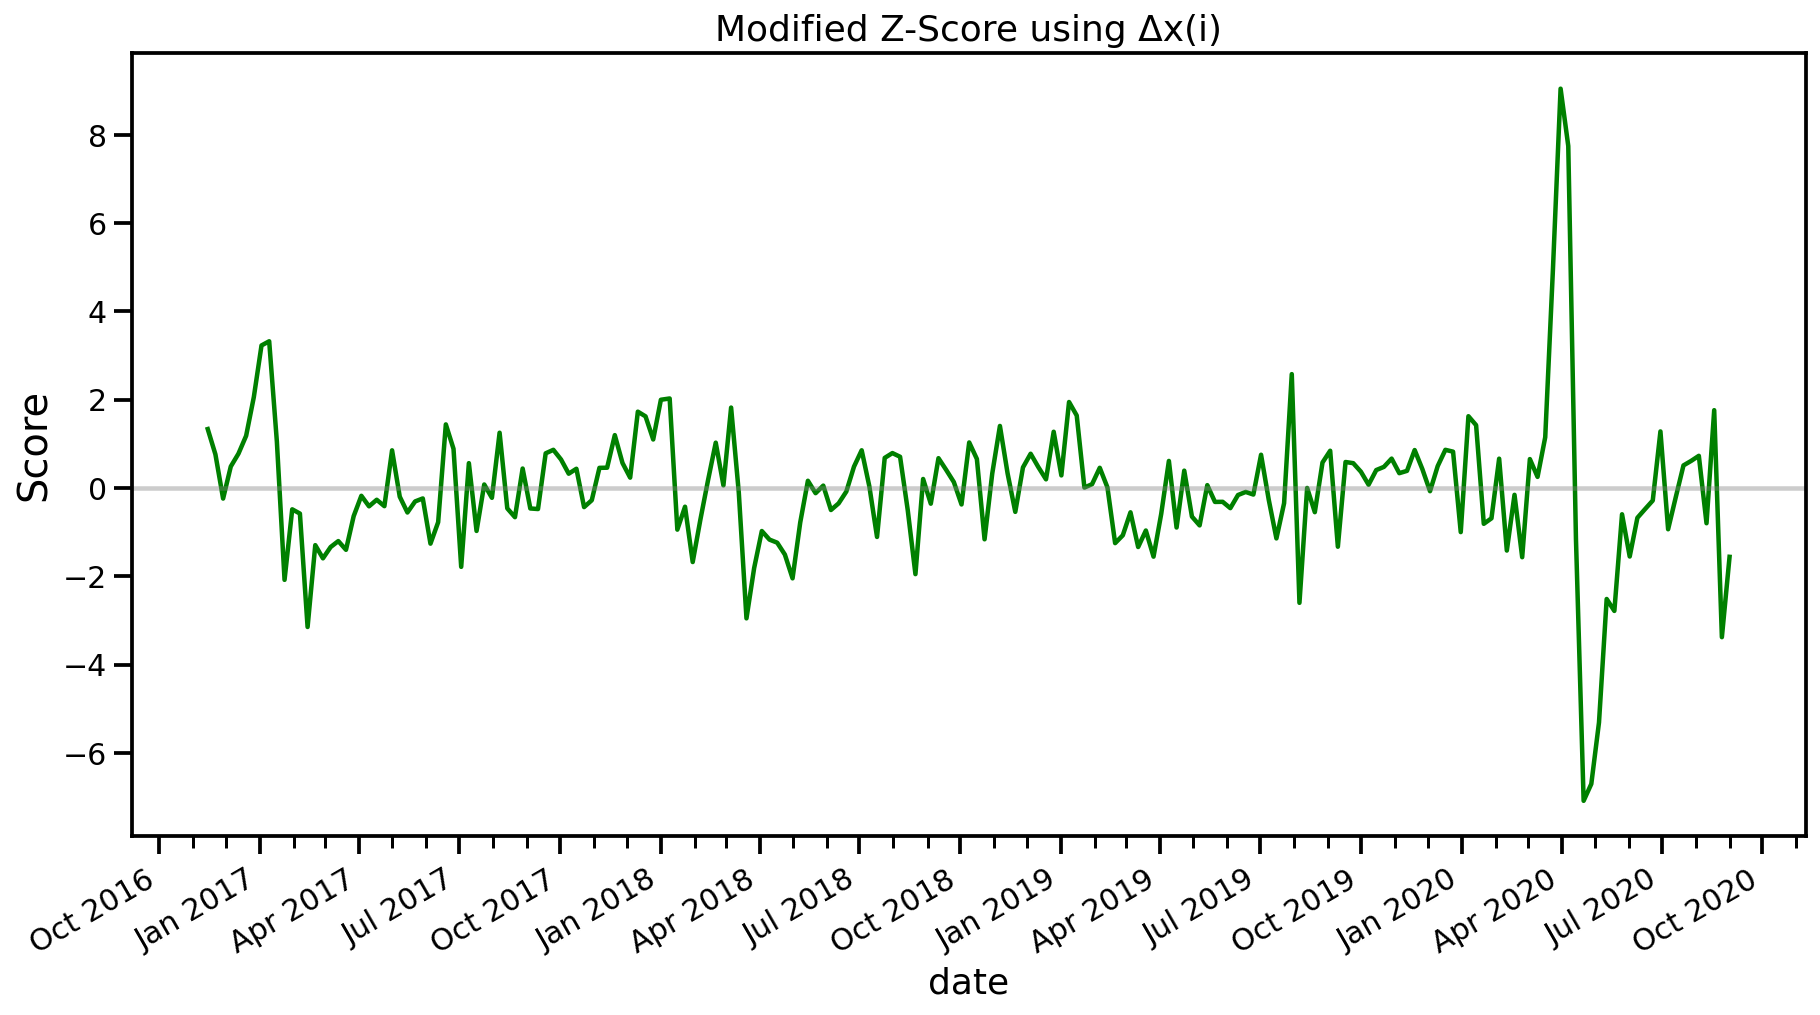

In [58]:
# data.plot(x='date',y='modified_z_score',ax=ax,legend=False,color='green')
# plt.axhline(threshold,color='gray',alpha=0.5,linestyle=':')
# #plt.xticks(fontsize = 15)
# #plt.yticks(fontsize = 15)
# plt.xlabel('date')# ,fontsize = 20)
# plt.ylabel('|modified Z-score|')# ,fontsize = 20)
# plt.title('EUROMOMO deaths: |modified Z-score| since end of 2015')

fig, ax = plt.subplots(figsize=(15, 8))
data.plot(x='date',y='modified_z_score_delta',ax=ax,legend=False,color='green')
plt.axhline(0,color='gray',alpha=0.4)
#plt.plot(data.date.index[1:], modified_z_score)
plt.title('Modified Z-Score using Δx(i)')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('date')

ax.xaxis.set_major_locator(mdates.YearLocator())

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

ax.xaxis.set_minor_locator(mdates.MonthLocator())

#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.get_xaxis().set_tick_params(which='major', pad=5)
plt.ylabel('Score', fontsize = 20)
plt.show()

# All from https://towardsdatascience.com/removing-spikes-from-raman-spectra-8a9fdda0ac22

In [29]:
threshold = 3.5
intensity_modified_z_score = np.array(np.abs(modified_z_score(delta_int)))
plt.plot(wavelength[1:], intensity_modified_z_score)
plt.plot(wavelength[1:], threshold*np.ones(len(wavelength[1:])), label = 'threshold')
plt.title('Modified Z-Score of ∇x(i)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Wavelength (nm)', fontsize = 20)
plt.ylabel('Score', fontsize = 20)
plt.show()

TypeError: 'numpy.ndarray' object is not callable

In [30]:
# 1 is assigned to spikes, 0 to non-spikes:
spikes = abs(np.array(calc_modified_z_score(intensity))) > threshold
plt.plot(wavelength, spikes, color = 'red')
plt.title('Spikes: ' + str(np.sum(spikes)), fontsize = 20)
plt.grid()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel( 'Wavelength' ,fontsize = 20)
#plt.ylabel( ‘Spike(1) or not(0)?’ ,fontsize = 20)
plt.show()

NameError: name 'intensity' is not defined

In [31]:
plt.plot(wavelength[1:],
np.array(abs(calc_modified_z_score(delta_int))), color='black', label = '|Modified Z-Score using ∇x(i)|')
plt.plot(wavelength, np.array(abs(calc_modified_z_score(intensity))), label = '|Modified Z-Score|', color = 'red')
plt.plot(wavelength, np.array(abs(calc_z_score(intensity))), label = '|Z-Score|', color = 'blue')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel( 'Wavelength' ,fontsize = 20)
plt.ylabel( 'Score' ,fontsize = 20)
plt.legend()
plt.show()

NameError: name 'wavelength' is not defined

NameError: name 'wavelength' is not defined

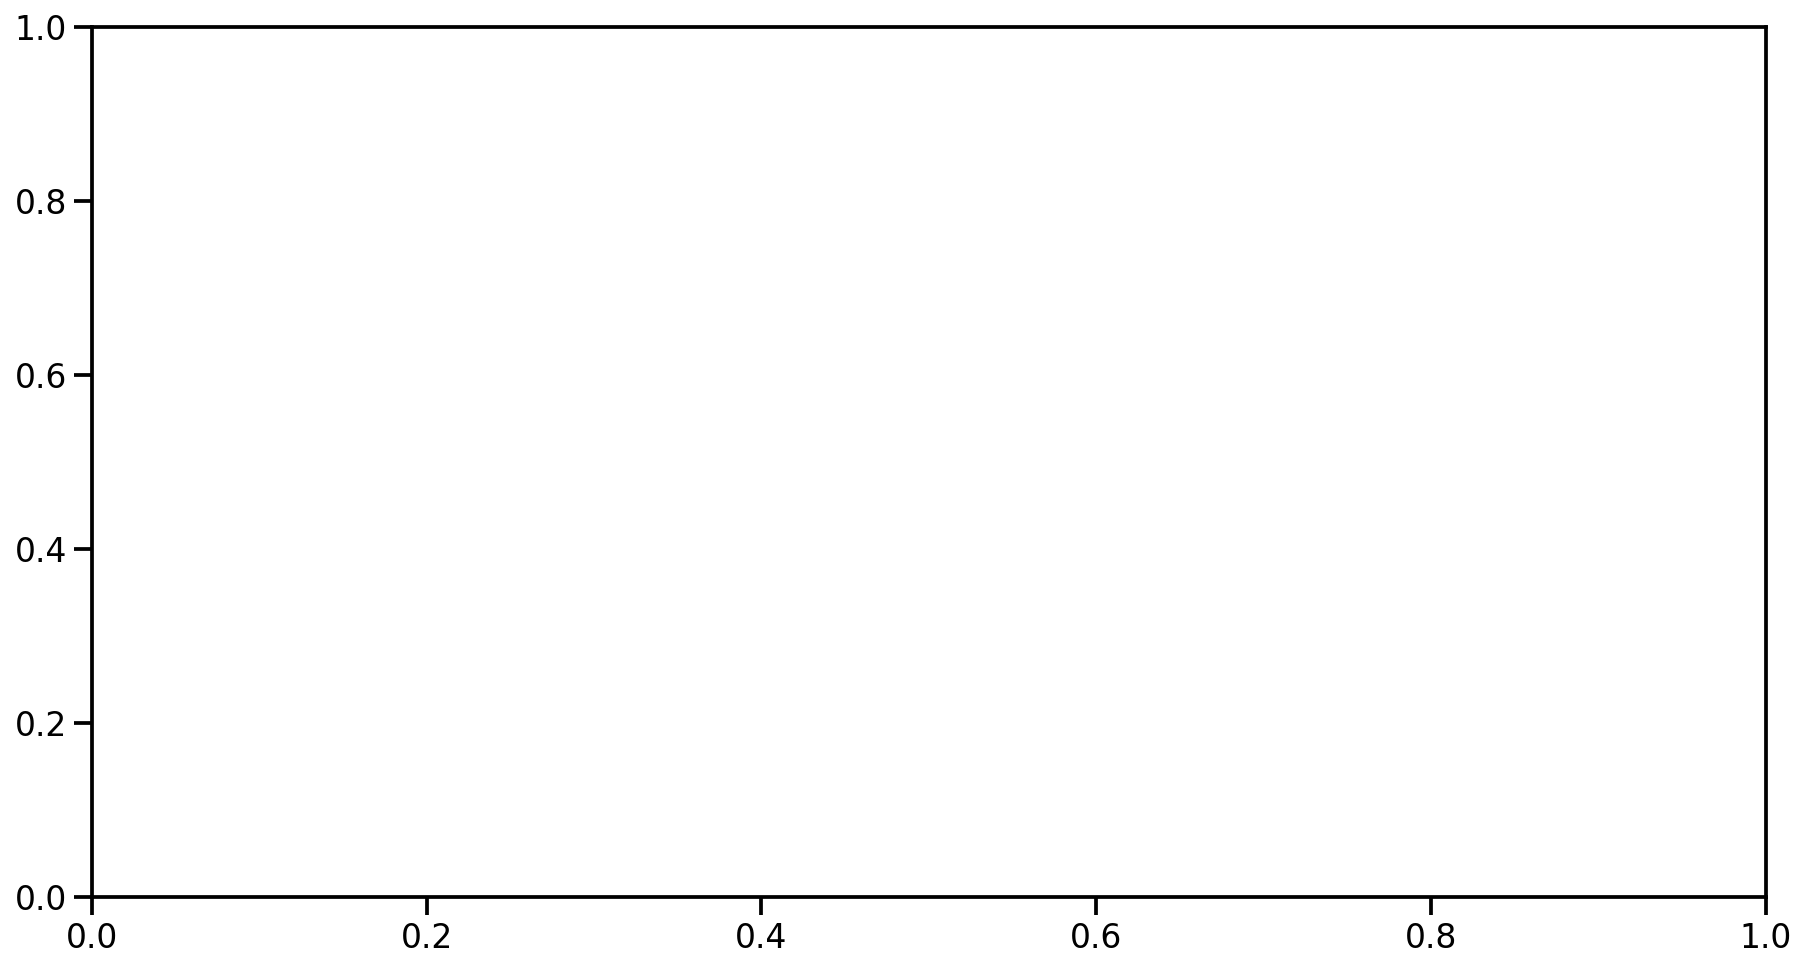

In [32]:
def fixer(y,m):
    threshold = 4 # binarization threshold. 
    spikes = abs(np.array(calc_modified_z_score(np.diff(y)))) > threshold
    y_out = y.copy() # So we don’t overwrite y
    for i in np.arange(len(spikes)):
        if spikes[i] != 0: # If we have an spike in position i
            w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
            w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
            y_out[i] = np.mean(y[w2]) # and we average their values
    return y_out

# Does it work?

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(wavelength, intensity, label = 'original data',color='blue',alpha=0.7)
plt.plot(wavelength, fixer(intensity,m=3), label = 'fixed spectrum',linestyle=':')
plt.title('Despiked spectrum',fontsize = 20)
#plt.xticks(fontsize = 15)
#plt.yticks(fontsize = 15)
plt.ylabel('deaths' ,fontsize = 20)
plt.xlabel('date index' ,fontsize = 20)
plt.legend()
plt.show()

In [33]:
totalcoviddeaths=(data.deaths-data.noncovidbaseline).cumsum()

euromomototalcoviddeaths=(pandemic.deaths-pandemic.baseline).cumsum()



data['euromomoexcess']=data.deaths-data.baseline
data['totalcoviddeaths']=pd.Series(totalcoviddeaths)
data['euromomototalcoviddeaths']=pd.Series(euromomototalcoviddeaths)

In [34]:
#data.merge(covidweekly,on='date',how='outer')

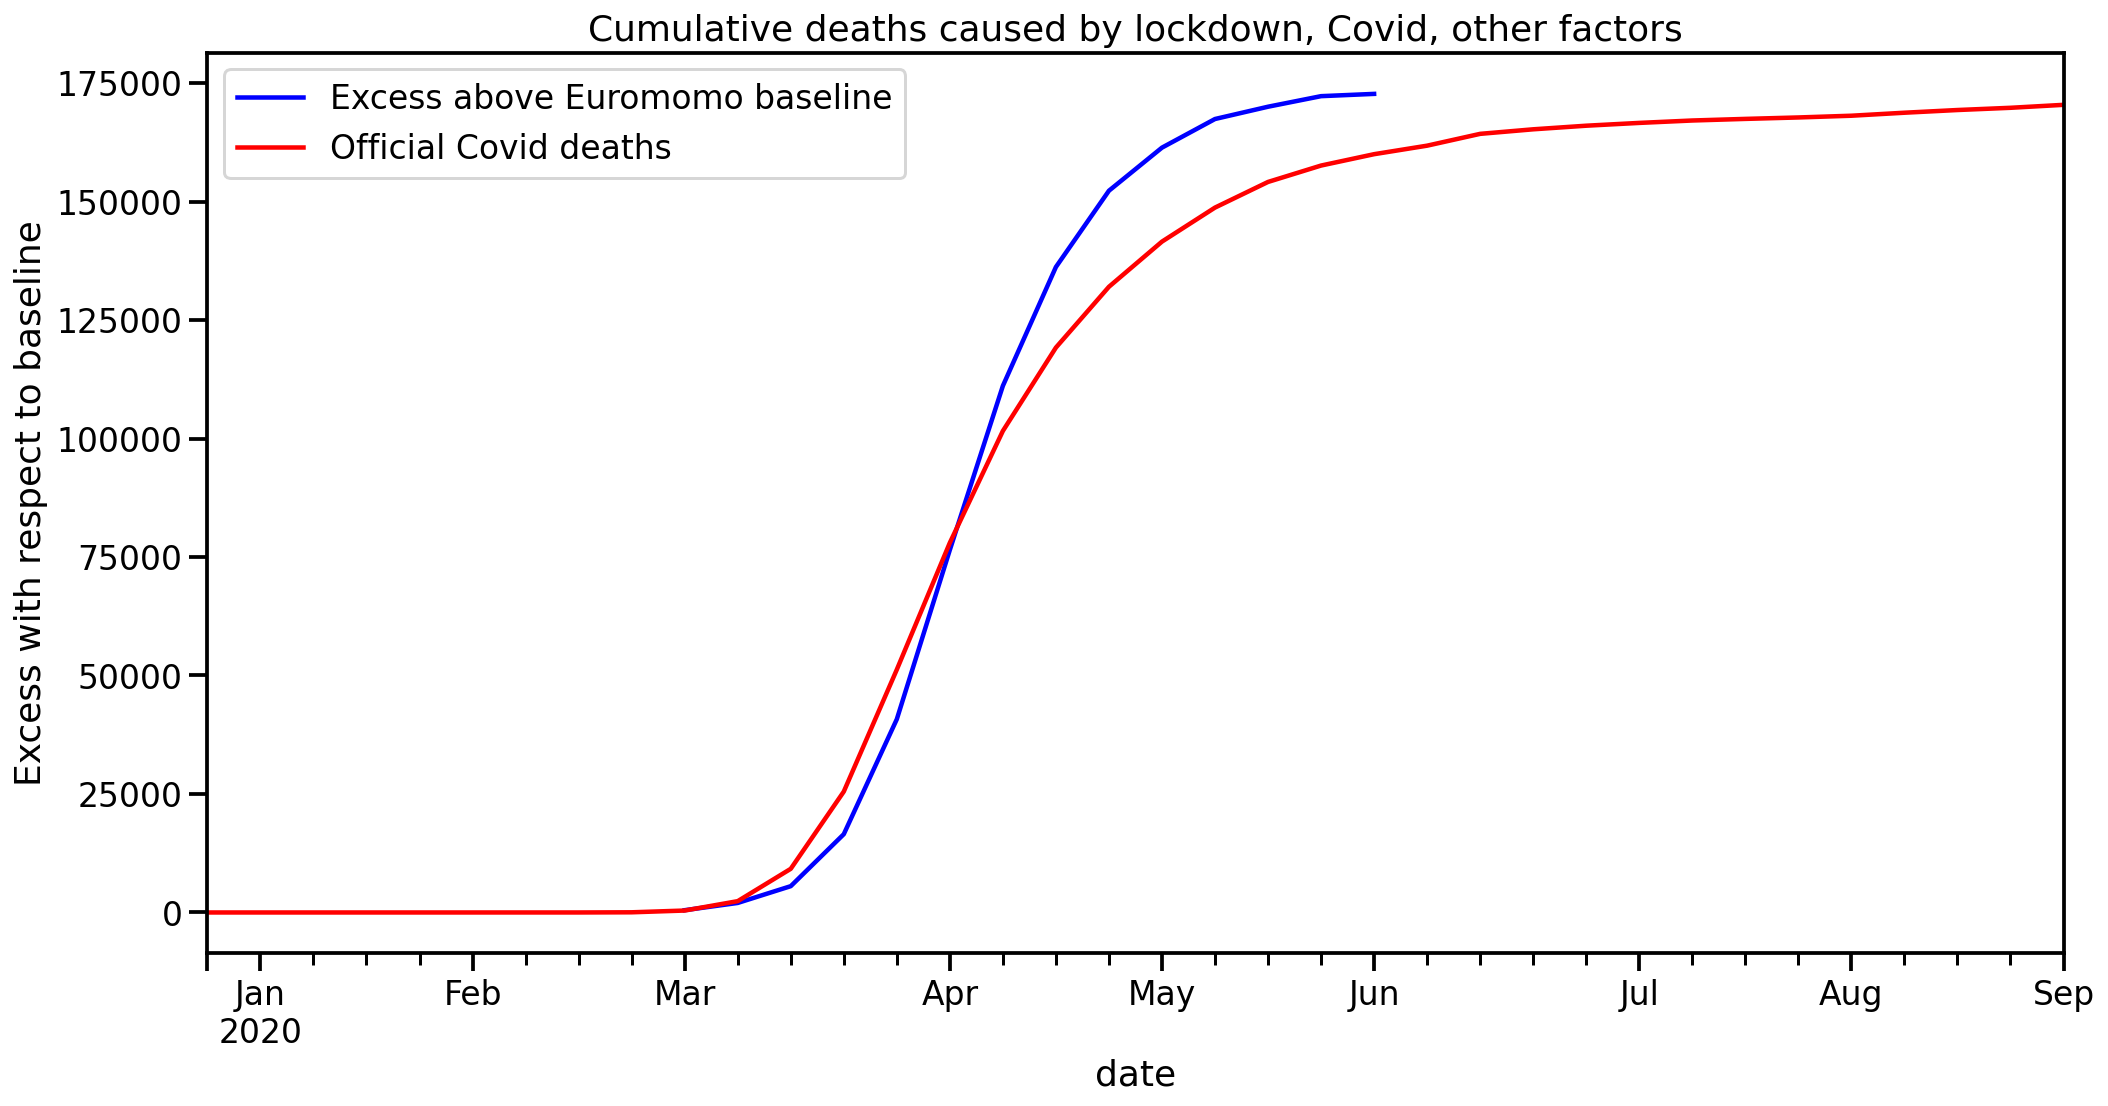

In [35]:
index=data[(data.date>pd.Timestamp('2020-02-26')) & (data.date<pd.Timestamp('2020-06-08'))].index

fig, ax = plt.subplots(figsize=(15, 8))


# (data.iloc[index]).plot(x='date',y='totalcoviddeaths',legend=False,ax=ax,
#                           color='crimson',label='Excess above hypothetical baseline')
(data.iloc[index]).plot(x='date',y='euromomototalcoviddeaths',legend=False,ax=ax,label='Excess above Euromomo baseline',color='blue')
###
covidweekly['deathscumulative']=covidweekly.deaths.cumsum()
covidweekly.plot(x='date',y='deathscumulative',label='Official Covid deaths',ax=ax,color='red')
#######

plt.xlabel('date')# ,fontsize = 20)
plt.ylabel('Excess with respect to baseline')# ,fontsize = 20)

plt.title('Cumulative deaths caused by lockdown, Covid, other factors')
#plt.title('EUROMOMO excess deaths during epidemic')

plt.legend()
fig.set_facecolor('w')
plt.tight_layout();
sns.despine;

#ax.xaxis.set_major_locator(mdates.YearLocator())

#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

#ax.xaxis.set_major_locator(mdates.MonthLocator())

#ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
#set major ticks format
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
#ax.get_xaxis().set_tick_params(which='major', pad=5)






plt.savefig('hypotheticalbaseline_excess.jpg',dpi=250)


40003.159999999974


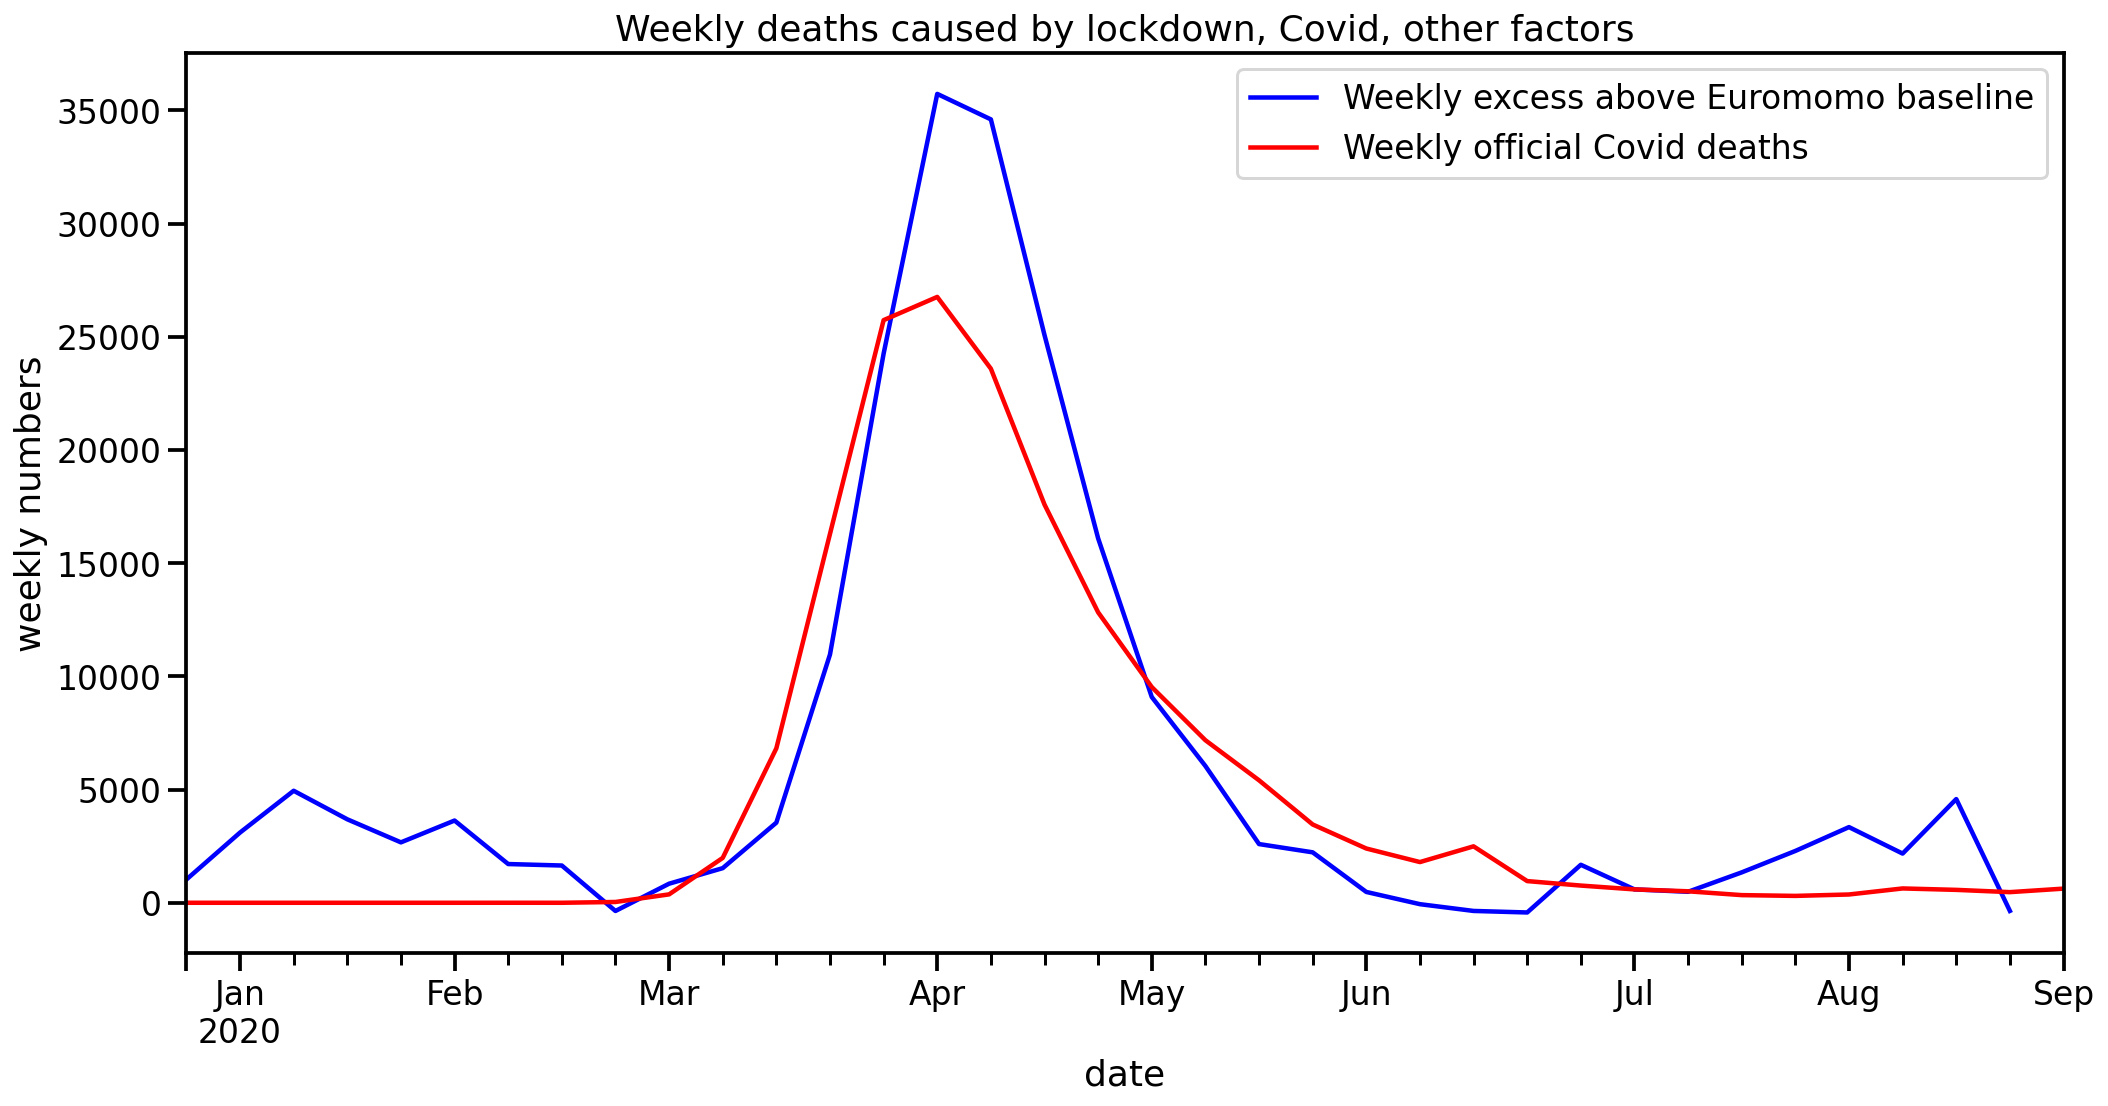

In [36]:
coviddeaths=data.deaths-data.noncovidbaseline
data['coviddeaths']=pd.Series(coviddeaths)


fig, ax = plt.subplots(figsize=(15, 8))
#data.iloc[index].plot(x='date',y='coviddeaths',label='Weekly excess above Euromomo baseline',ax=ax,color='blue')

index=data[data.date>=covidweekly.date.min()].index

data.iloc[index-1].plot(x='date',y='euromomoexcess',label='Weekly excess above Euromomo baseline',ax=ax,color='blue')



covidweekly.plot(x='date',y='deaths',label='Weekly official Covid deaths',ax=ax,color='red')


plt.legend()
plt.xlabel('date')# ,fontsize = 20)
plt.ylabel('weekly numbers')# ,fontsize = 20)
plt.title('Weekly deaths caused by lockdown, Covid, other factors')


fig.set_facecolor('w')
plt.tight_layout();
sns.despine;


plt.savefig('weekly_deaths.jpg',dpi=250)

print(data.iloc[index-1].euromomoexcess.sum() - covid.deaths.sum())



In [37]:



df=week2day(data)
df['dailyexcesssmooth']=df.dailyexcess.rolling(7, win_type='gaussian').mean(std=2.5)

In [38]:
#https://gateway.euro.who.int/en/indicators/hfamdb_98-deaths-all-causes/visualizations/#id=29302
#url='https://dw.euro.who.int/api/v3/export/HFAMDB_98?filter=SUBNATIONAL_MDB:$blank&amp;lang=EN&amp;format=xlsx'

In [39]:
#pd.read_excel(url)

In [40]:
# Get death data for Euromomo countries
countries=['Austria', 'Belgium', 'Denmark', 'Estonia', 'Finland', 'France','Greece', 'Ireland', 
           'Italy', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden', 'Switzerland',
           'UK','Berlin']
           
          # 'Germany (Berlin),

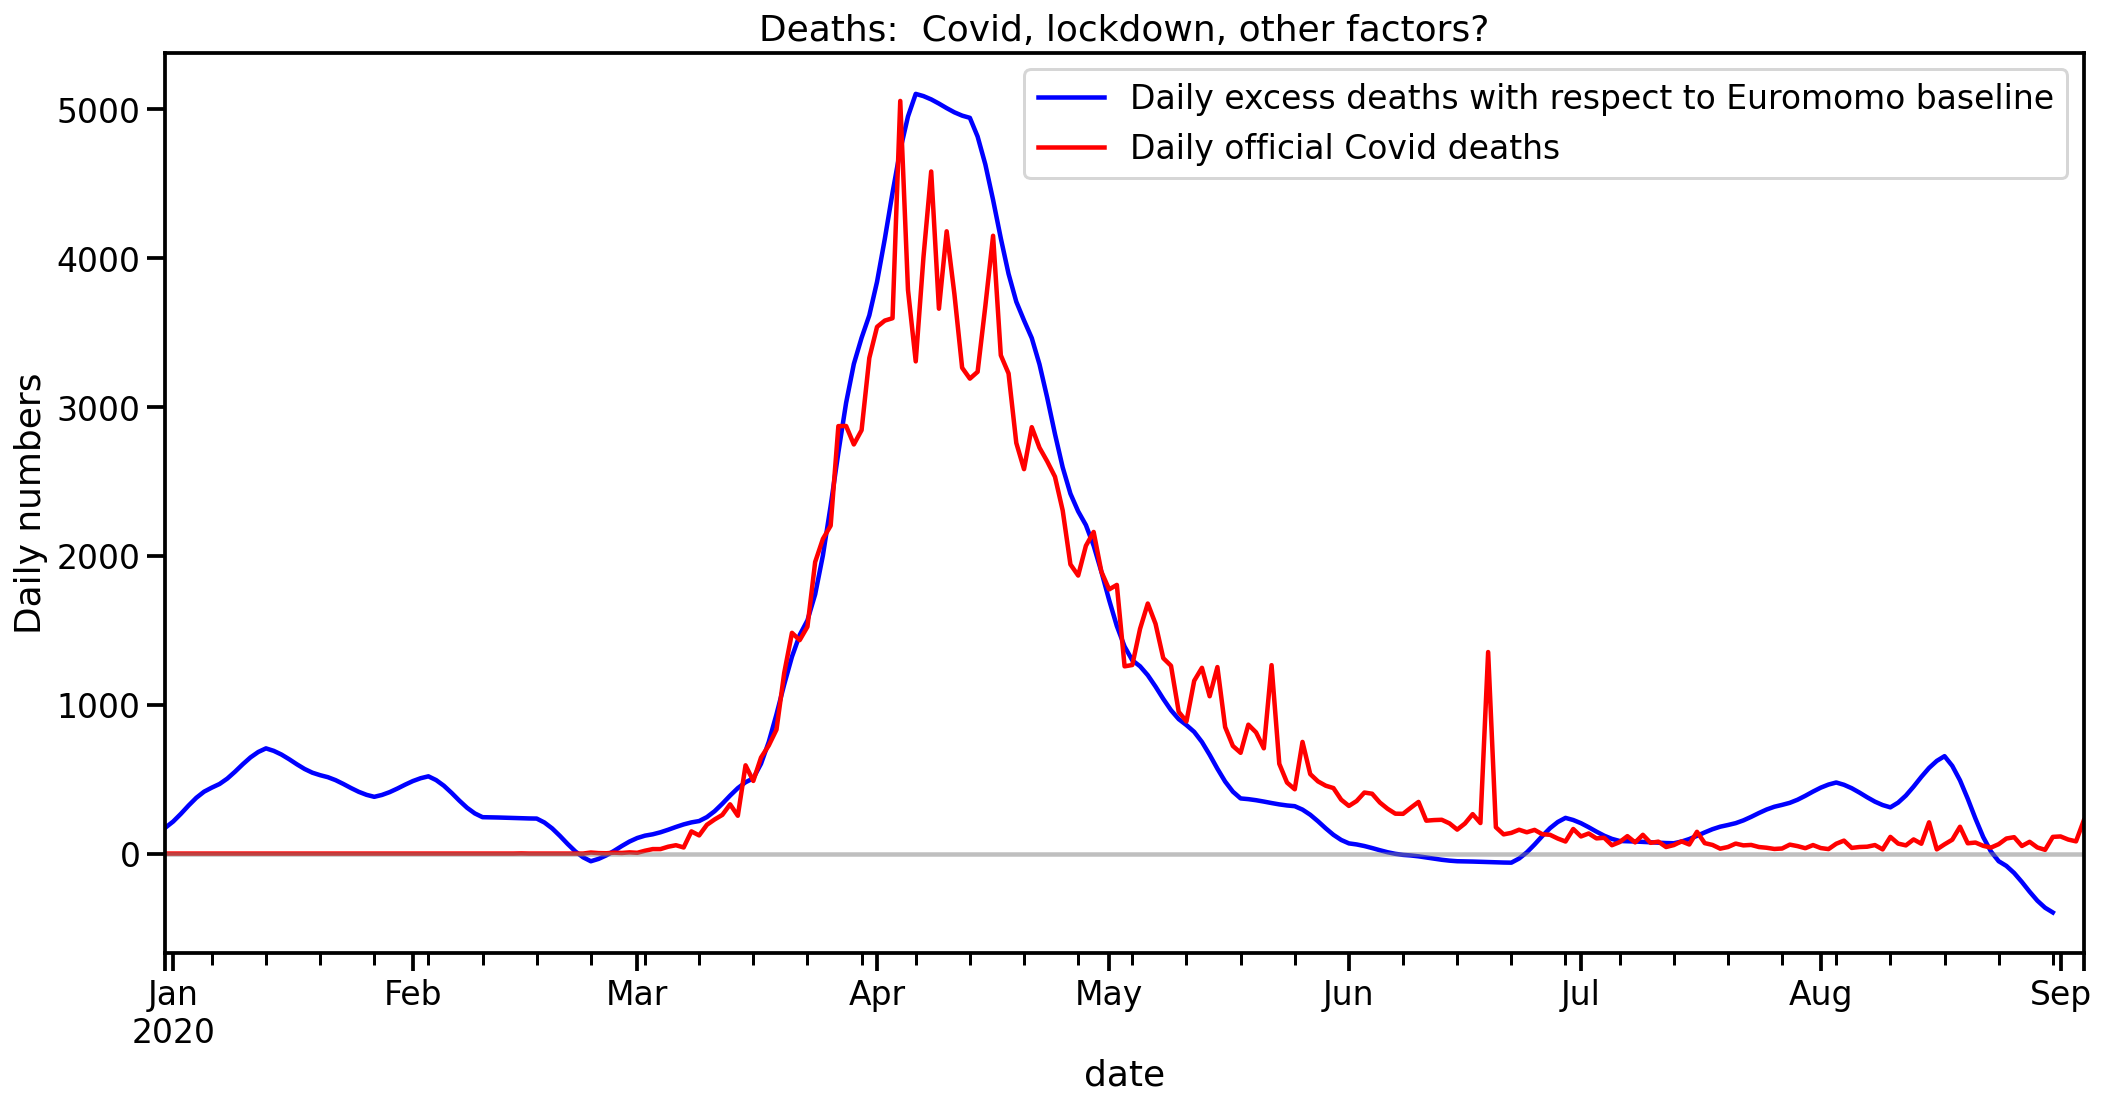

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))



index=df[df.date>=covid.date.min()].index

df.iloc[index].plot(x='date',y='dailyexcesssmooth',ax=ax,label='Daily excess deaths with respect to Euromomo baseline',color='blue')
covid.plot(x='date',y='deaths',ax=ax,label='Daily official Covid deaths',color='red')

plt.xlabel('date')# ,fontsize = 20)
plt.ylabel('Daily numbers')# ,fontsize = 20)
plt.axhline(0,color='gray',alpha=0.5)

plt.title('Deaths:  Covid, lockdown, other factors?')
#plt.title('EUROMOMO excess deaths during epidemic')

plt.legend()
fig.set_facecolor('w')
plt.tight_layout();
sns.despine;

plt.savefig('Excess_v_Covid_smoothed.png',dpi=250)

In [ ]:
# FR=df[df.state=='France']
# fig, ax = plt.subplots(figsize=(15, 8))
# FR.plot(x='date',y='deaths',ax=ax,legend=False)
# plt.ylabel('daily deaths')
# plt.title('France: daily deaths')
# plt.savefig('FRdeaths.png',dpi=200)

